## **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gzip
import json
import re
import os
from tqdm import tqdm
import requests
from io import BytesIO
from pickle import dump, load
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances
import scipy.sparse
from scipy.sparse import hstack
from scipy import stats
from scipy.sparse import coo_matrix
from surprise import Reader, Dataset
from surprise import SVD, model_selection, accuracy
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

## **Data content in user and book .gz file**

In [ ]:
with gzip.open('/content/goodreads_reviews_dedup.json.gz') as f:
  line = f.readline()
json.loads(line)  

{'book_id': '24375664',
 'date_added': 'Fri Aug 25 13:55:02 -0700 2017',
 'date_updated': 'Mon Oct 09 08:55:59 -0700 2017',
 'n_comments': 0,
 'n_votes': 16,
 'rating': 5,
 'read_at': 'Sat Oct 07 00:00:00 -0700 2017',
 'review_id': '5cd416f3efc3f944fce4ce2db2290d5e',
 'review_text': "Mind blowingly cool. Best science fiction I've read in some time. I just loved all the descriptions of the society of the future - how they lived in trees, the notion of owning property or even getting married was gone. How every surface was a screen. \n The undulations of how society responds to the Trisolaran threat seem surprising to me. Maybe its more the Chinese perspective, but I wouldn't have thought the ETO would exist in book 1, and I wouldn't have thought people would get so over-confident in our primitive fleet's chances given you have to think that with superior science they would have weapons - and defenses - that would just be as rifles to arrows once were. \n But the moment when Luo Ji won a

In [ ]:
with gzip.open('/content/goodreads_books.json.gz', 'r') as f:
  line = f.readline()
json.loads(line)  

{'asin': '',
 'authors': [{'author_id': '604031', 'role': ''}],
 'average_rating': '4.00',
 'book_id': '5333265',
 'country_code': 'US',
 'description': '',
 'edition_information': '',
 'format': 'Paperback',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'is_ebook': 'false',
 'isbn': '0312853122',
 'isbn13': '9780312853129',
 'kindle_asin': '',
 'language_code': '',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'num_pages': '256',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'publication_day': '1',
 'publication_month': '9',
 'publication_year': '1984',
 'publisher': "St. Martin's Press",
 'ratings_count': '3',
 'series': [],
 'similar_books': [],
 'text_reviews_count': '1',
 'title': 'W.C. Fields: A Life on Film',
 'title_without_series': 'W.C. Fields: A Life on Film',
 'u

## **Parsers**

In [ ]:
def user_parser(line):
  data = {
      'book_id': line['book_id'],
      'user_id': line['user_id'],
      'review_text': line['review_text'],
      'n_votes': line['n_votes'],
      'user_rating': line['rating']
  } 
  return data

def book_parser(line):
  data = {
      'book_id': line['book_id'],
      'title_without_series': line['title_without_series'],
      'book_description': line['description'],
      'publication_year': line['publication_year'],
      'publisher': line['publisher'],
      'ratings_count': line['ratings_count'],
      'book_average_rating': line['average_rating'],
      'cover_page': line['image_url'],
      'book_url': line['url'],
      'is_ebook': line['is_ebook'],
      'num_pages': line['num_pages'],
  }
  return data

## **Books csv**

In [ ]:
books = list()
with gzip.open('/content/goodreads_books.json.gz', 'r') as f:
  while True:
    line = f.readline()
    if not line:
      break
    book = book_parser(json.loads(line))
    try:
      if int(book['ratings_count'])>15:
        books.append(book)
    except Exception:
      continue    

df_books = pd.DataFrame.from_dict(books)
df_books.to_csv('df_books.csv.gz', index=False, compression='gzip')      

In [ ]:
df_books = pd.read_csv('/content/df_books.csv.gz')
df_books.head(3)

,book_id,title_without_series,book_description,publication_year,publisher,ratings_count,book_average_rating,cover_page,book_url,is_ebook,num_pages
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,1987.0,"Nelson Doubleday, Inc.",140,4.03,https://images.gr-assets.com/books/1304100136m...,https://www.goodreads.com/book/show/7327624-th...,False,600.0
1,6066819,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,2009.0,Atria Books,51184,3.49,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/6066819-be...,False,368.0
2,287141,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",2006.0,Yesterday's Classics,46,4.13,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/287141.The...,False,162.0


## **Users csv**

In [ ]:
users = list()
with gzip.open('/content/goodreads_reviews_dedup.json.gz', 'r') as f:
  while True:
    line = f.readline()
    if not line:
      break
    user = user_parser(json.loads(line))
    users.append(user)

df_users = pd.DataFrame.from_dict(users)
df_users.to_csv('df_users.csv.gz', index=False, compression='gzip')

In [ ]:
df_users = pd.read_csv('/content/df_users.csv.gz')
df_users.head(3)

,book_id,user_id,review_text,n_votes,user_rating
0,24375664,8842281e1d1347389f2ab93d60773d4d,Mind blowingly cool. Best science fiction I've...,16,5
1,18245960,8842281e1d1347389f2ab93d60773d4d,This is a special book. It started slow for ab...,28,5
2,6392944,8842281e1d1347389f2ab93d60773d4d,I haven't read a fun mystery book in a while a...,6,3


## **Preprocessing**

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_numeric_data(dataframe, df_name):
  if df_name == 'df_books_copy':
    dataframe["book_average_rating"] = pd.to_numeric(dataframe["book_average_rating"])
    dataframe["publication_year"] = pd.to_numeric(dataframe["publication_year"])
    dataframe["ratings_count"] = dataframe["ratings_count"].astype(int)
    dataframe["num_pages"] = pd.to_numeric(dataframe["num_pages"])
    dataframe["is_ebook"] = dataframe["is_ebook"].map({True:1, False:0})
  else:
    dataframe["user_rating"] = dataframe["user_rating"].astype(int)
    dataframe["book_id"] = dataframe["book_id"].astype(int)
    dataframe["n_votes"] = dataframe["n_votes"].astype(int)
  return dataframe

def preprocess_text_data(dataframe, df_name):
  dataframe["book_id"] = dataframe["book_id"].astype(str)
  if df_name == 'df_books_numeric_mod':
    dataframe["mod_title"] = dataframe["title_without_series"].astype(str).apply(decontracted)
    dataframe["mod_title"] = dataframe["mod_title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["mod_title"] = dataframe["mod_title"].astype(str).apply(lambda sentence: ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords and len(e.lower())>1))
    dataframe["mod_title"] = dataframe["mod_title"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["mod_title"].str.len() > 0]

    dataframe["book_description"] = dataframe["book_description"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["book_description"] = dataframe["book_description"].str.lower()
    dataframe["book_description"] = dataframe["book_description"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["book_description"].str.len() > 0]

    dataframe["publisher"] = dataframe["publisher"].str.replace("[^a-zA-Z0-9 ]", "", regex=True)
    dataframe["publisher"] = dataframe["publisher"].str.lower()
    dataframe["publisher"] = dataframe["publisher"].str.replace("\s+", " ", regex=True)
    dataframe = dataframe[dataframe["publisher"].str.len() > 0]
  else:
    dataframe["user_id"] = dataframe["user_id"].astype(str)

  return dataframe  

***Creating copy and calling above functions***

In [ ]:
df_books_copy = df_books.copy()

df_books_numeric_mod = preprocess_numeric_data(df_books_copy, 'df_books_copy')
df_books_processed = preprocess_text_data(df_books_numeric_mod, 'df_books_numeric_mod')
df_users_numeric_mod = preprocess_numeric_data(df_users, 'df_users')
df_users_processed = preprocess_text_data(df_users_numeric_mod, 'df_users_numeric_mod')

***Finding duplicates in df_books_processed***

In [ ]:
df_books_processed[['mod_title', 'book_average_rating']].duplicated().sum()

177097

***Removing duplicate entries***

In [ ]:
df_books_processed.drop_duplicates(subset=['mod_title', 'book_average_rating'], keep='first', inplace=True)
df_books_processed.shape

(678274, 12)

***Finding duplicates in df_users_processed***

In [ ]:
df_users_processed[['user_id','book_id','user_rating']].duplicated().sum()

0

***Finding features with null entries in df_books_processed and processing them***

In [ ]:
df_books_processed.isnull().any(axis=0)

book_id                 False
title_without_series    False
book_description        False
publication_year         True
publisher               False
ratings_count           False
book_average_rating     False
cover_page              False
book_url                False
is_ebook                False
num_pages                True
mod_title               False
dtype: bool

We cannot drop the missing values row directly as feature values fall in useful domain 

In [ ]:
df_books_processed[df_books_processed.isnull().any(axis=1)][['ratings_count', 'book_average_rating']].describe()

,ratings_count,book_average_rating
count,69462.000000,69462.000000
mean,212.365034,3.901471
std,2188.212652,0.388506
min,16.000000,1.280000
25%,25.000000,3.670000
50%,46.000000,3.920000
75%,110.000000,4.170000
max,265189.000000,5.000000


***Filling the missing values in features with median values of their column, medians are resistant to outlier***

In [ ]:
df_books_processed['publication_year'] = df_books_processed['publication_year'].fillna(df_books_processed['publication_year'].median())
df_books_processed['num_pages'] = df_books_processed['num_pages'].fillna(df_books_processed['num_pages'].median())

In [ ]:
df_books_processed.isnull().any(axis=0)

book_id                 False
title_without_series    False
book_description        False
publication_year        False
publisher               False
ratings_count           False
book_average_rating     False
cover_page              False
book_url                False
is_ebook                False
num_pages               False
mod_title               False
dtype: bool

***Finding features with null entries in df_users_processed and processing them***

In [ ]:
df_users_processed.isnull().any(axis=0)

book_id        False
user_id        False
review_text     True
n_votes        False
user_rating    False
dtype: bool

***Removing the missing values in review_text***

In [ ]:
df_users_processed.dropna(axis=0, inplace=True)

In [ ]:
df_users_processed.isnull().any(axis=0)

book_id        False
user_id        False
review_text    False
n_votes        False
user_rating    False
dtype: bool

***Visualizing the remaining features with their shapes in each dataframe***

In [ ]:
print('df_users_processed features: ', list(df_users_processed.columns))
print('df_books_processed features: ', list(df_books_processed.columns))

df_users_processed features:  ['book_id', 'user_id', 'review_text', 'n_votes', 'user_rating']
df_books_processed features:  ['book_id', 'title_without_series', 'book_description', 'publication_year', 'publisher', 'ratings_count', 'book_average_rating', 'cover_page', 'book_url', 'is_ebook', 'num_pages', 'mod_title']


In [ ]:
print('df_users_processed shape: ', df_users_processed.shape)
print('df_books_processed shape: ', df_books_processed.shape)

df_users_processed shape:  (15732899, 5)
df_books_processed shape:  (678274, 12)


Observation:


*   After removing duplicate and null entries from df_users_processed, we have 1,57,32,899 entries present
*   After removing duplicate and null entries from df_books_processed, we have 6,78,274 entries present


***Saving processed files***

In [ ]:
df_books_processed.to_csv('df_books_processed.csv.gz', index=False, compression='gzip')
df_users_processed.to_csv('df_users_processed.csv.gz', index=False, compression='gzip')

*Merging* **df_books_processed and df_users_processed** 

In [ ]:
df_books_users = pd.merge(df_books_processed, df_users_processed, on='book_id', how='inner')

***Checking for any features with null entries after merge operation***

In [ ]:
df_books_users.isnull().any()

book_id                 False
title_without_series    False
book_description        False
publication_year        False
publisher               False
ratings_count           False
book_average_rating     False
cover_page              False
book_url                False
is_ebook                False
num_pages               False
mod_title               False
user_id                 False
review_text             False
n_votes                 False
user_rating             False
dtype: bool

***Function for user interface***

In [7]:
def make_clickable(val):
    return '<a target="_blank" href="{}">Goodreads</a>'.format(val, val)

def show_image(val):
    return '<a href="{}"><img src="{}" width=60></img></a>'.format(val, val)

## **EDA**

### ***n_votes***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['n_votes'], i))

0th percentile is -3.0
10th percentile is 0.0
20th percentile is 0.0
30th percentile is 0.0
40th percentile is 0.0
50th percentile is 0.0
60th percentile is 0.0
70th percentile is 0.0
80th percentile is 1.0
90th percentile is 2.0
100th percentile is 1464.0


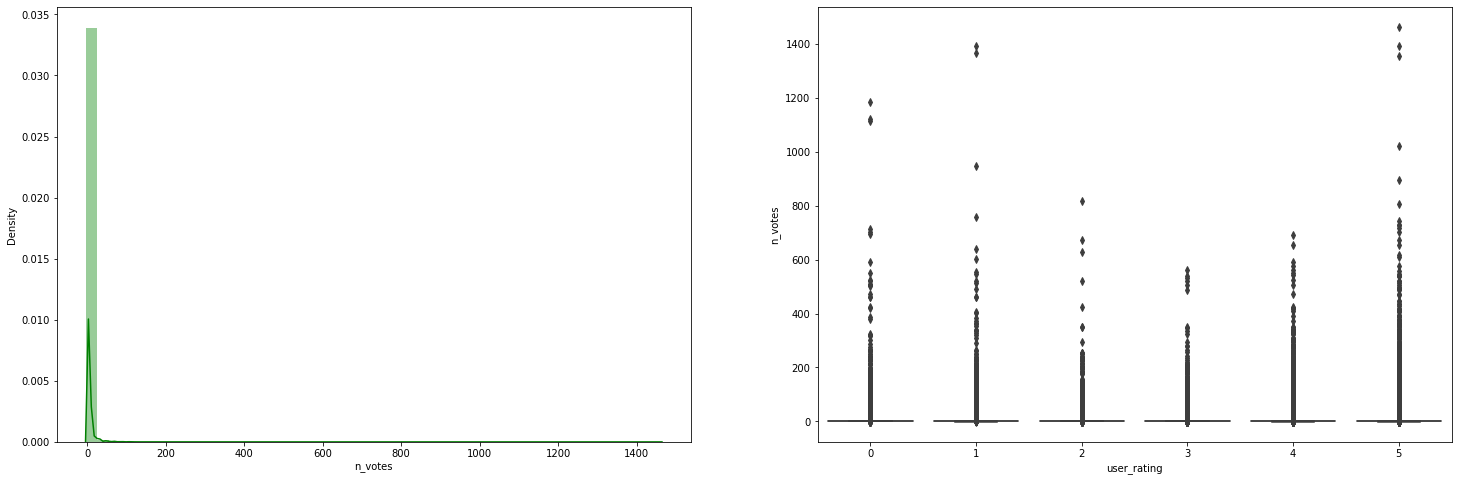

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['n_votes'], ax=axes[0], color='green')
sns.boxplot(y= 'n_votes', data=df_books_users, ax=axes[1],  x='user_rating')
plt.show()

In [ ]:
df_books_users.drop(columns=['n_votes'], inplace=True)

Observation:

*   We can see that 90% of the data has less than 2 votes, most the books got 0 votes. 
*   Same could be visualized from distplot and boxplot, this feature is not useful, we will drop it.



### ***num_pages***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

0th percentile is 0.0
10th percentile is 100.0
20th percentile is 176.0
30th percentile is 224.0
40th percentile is 256.0
50th percentile is 281.0
60th percentile is 311.0
70th percentile is 341.0
80th percentile is 382.0
90th percentile is 440.0
100th percentile is 945077.0


In [ ]:
for i in range(0, 11, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

0th percentile is 0.0
1th percentile is 24.0
2th percentile is 32.0
3th percentile is 32.0
4th percentile is 36.0
5th percentile is 40.0
6th percentile is 48.0
7th percentile is 63.0
8th percentile is 76.0
9th percentile is 90.0
10th percentile is 100.0


In [ ]:
for i in range(90, 101, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['num_pages'], i))

90th percentile is 440.0
91th percentile is 448.0
92th percentile is 464.0
93th percentile is 476.0
94th percentile is 494.0
95th percentile is 512.0
96th percentile is 544.0
97th percentile is 590.0
98th percentile is 660.0
99th percentile is 767.0
100th percentile is 945077.0


In [ ]:
print('num_pages >=55000 :-   ', df_books_users[df_books_users['num_pages']>=55000.0]['num_pages'].count())
print('num_pages <=4 :-       ', df_books_users[(df_books_users['num_pages']<=4)]['num_pages'].count())

num_pages >=55000 :-    4
num_pages <=4 :-        11349


In [ ]:
df_books_users = df_books_users[df_books_users['num_pages']>4]

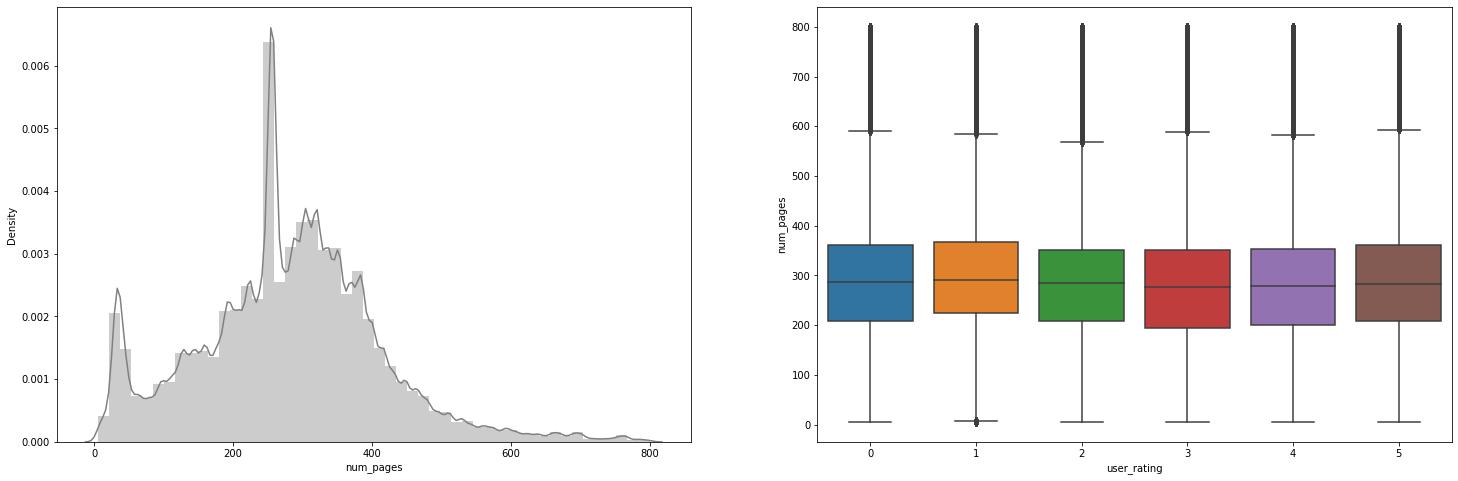

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
filter_data = df_books_users[df_books_users['num_pages']<=800.0]
sns.distplot(filter_data['num_pages'], ax=axes[0], color='grey')
sns.boxplot(y= 'num_pages', data=filter_data[(filter_data['book_average_rating']>2.6) & (filter_data['book_average_rating']<4.8)] , ax=axes[1],  x='user_rating')
plt.show()

Observation:


*   99% of the books have less than 767 pages.
*   There are 4 books which have >= 55000 pages, they are the oxford dictionary, wikipedia translated books.They could have those number of pages, we cannot drop them.
*   There are nearly 11349 books which have <=4 pages, this is absurd.These are outliers we will drop them.



### ***publication_year***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

0th percentile is 1.0
10th percentile is 2002.0
20th percentile is 2007.0
30th percentile is 2009.0
40th percentile is 2011.0
50th percentile is 2012.0
60th percentile is 2013.0
70th percentile is 2014.0
80th percentile is 2015.0
90th percentile is 2016.0
100th percentile is 21016.0


In [ ]:
for i in range(90, 101, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

90th percentile is 2016.0
91th percentile is 2016.0
92th percentile is 2016.0
93th percentile is 2016.0
94th percentile is 2016.0
95th percentile is 2016.0
96th percentile is 2017.0
97th percentile is 2017.0
98th percentile is 2017.0
99th percentile is 2017.0
100th percentile is 21016.0


In [ ]:
for i in range(0, 11, 1):
  print(f'{i}th percentile is', np.percentile(df_books_users['publication_year'], i))

0th percentile is 1.0
1th percentile is 1982.0
2th percentile is 1989.0
3th percentile is 1992.0
4th percentile is 1995.0
5th percentile is 1997.0
6th percentile is 1998.0
7th percentile is 1999.0
8th percentile is 2000.0
9th percentile is 2001.0
10th percentile is 2002.0


In [ ]:
print('publication_year <1850.0 :-   ', df_books_users[df_books_users['publication_year']<1850.0]['publication_year'].count())
print('publication_year >2022.0 :-   ', df_books_users[df_books_users['publication_year']>2022.0]['publication_year'].count())

publication_year <1850.0 :-    683
publication_year >2022.0 :-    370


In [ ]:
df_books_users = df_books_users[(df_books_users['publication_year']>=1850.0)]
df_books_users = df_books_users[(df_books_users['publication_year']<=2022.0)]

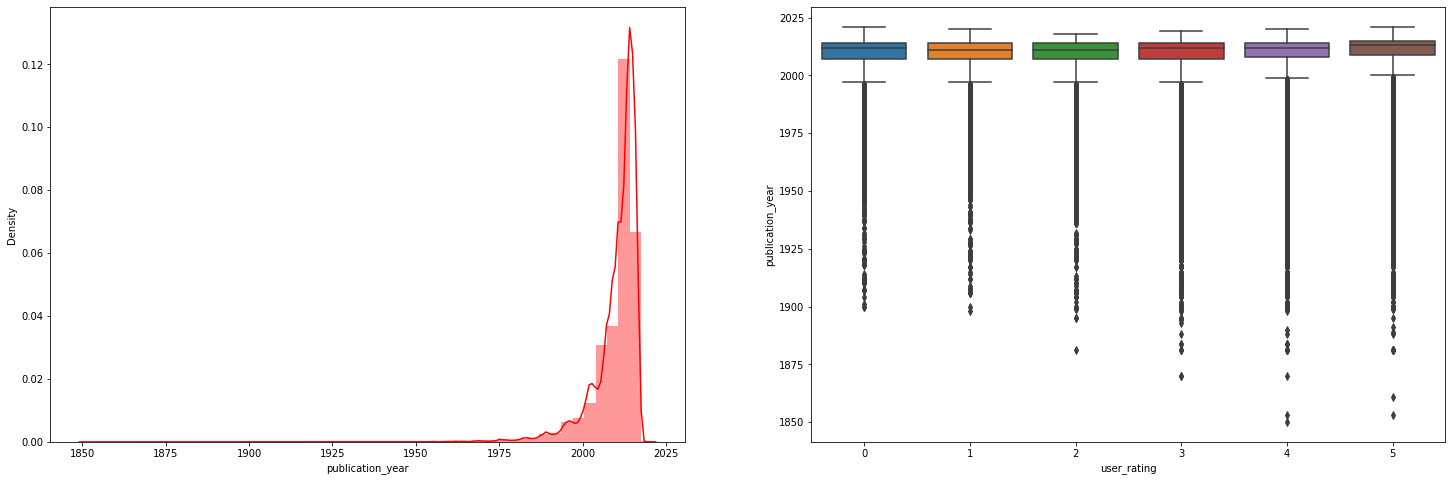

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['publication_year'], ax=axes[0], color='red')
sns.boxplot(y= 'publication_year', data=df_books_users[(df_books_users['book_average_rating']>2.6) & (df_books_users['book_average_rating']<4.8)] , ax=axes[1],  x='user_rating')
plt.show()

Observation:


*   There were some outliers, publication_year for some books was >2022 and there were some books where publication year<1850.
*   We removed the outlier data points from our dataset.



### ***book_average_rating***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['book_average_rating'], i))

0th percentile is 1.0
10th percentile is 3.49
20th percentile is 3.65
30th percentile is 3.76
40th percentile is 3.85
50th percentile is 3.93
60th percentile is 4.0
70th percentile is 4.09
80th percentile is 4.18
90th percentile is 4.3
100th percentile is 5.0


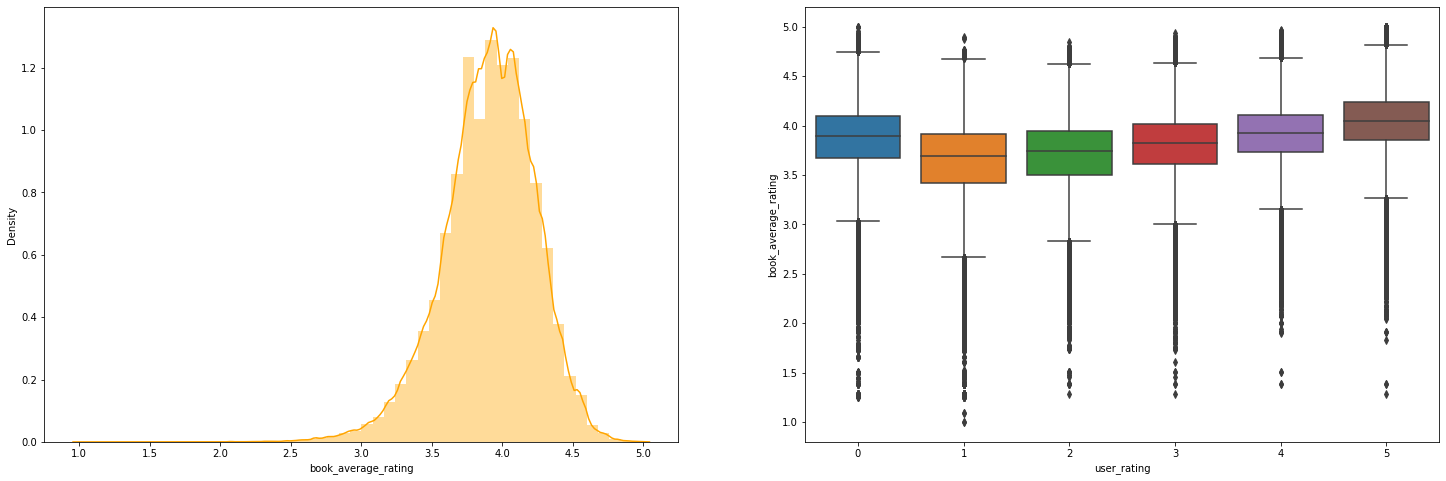

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['book_average_rating'], ax=axes[0], color='orange')
sns.boxplot(y= 'book_average_rating', data=df_books_users, ax=axes[1],  x='user_rating')
plt.show()

Onservation:

*   We can see that majority of books have got average rating of 3.8 and there are very few books which has very high and low average-rating, which is expected.
*   We cannot drop the books in any range on this feature.


### ***is_ebook***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['is_ebook'], i))

0th percentile is 0.0
10th percentile is 0.0
20th percentile is 0.0
30th percentile is 0.0
40th percentile is 0.0
50th percentile is 0.0
60th percentile is 0.0
70th percentile is 0.0
80th percentile is 0.0
90th percentile is 1.0
100th percentile is 1.0


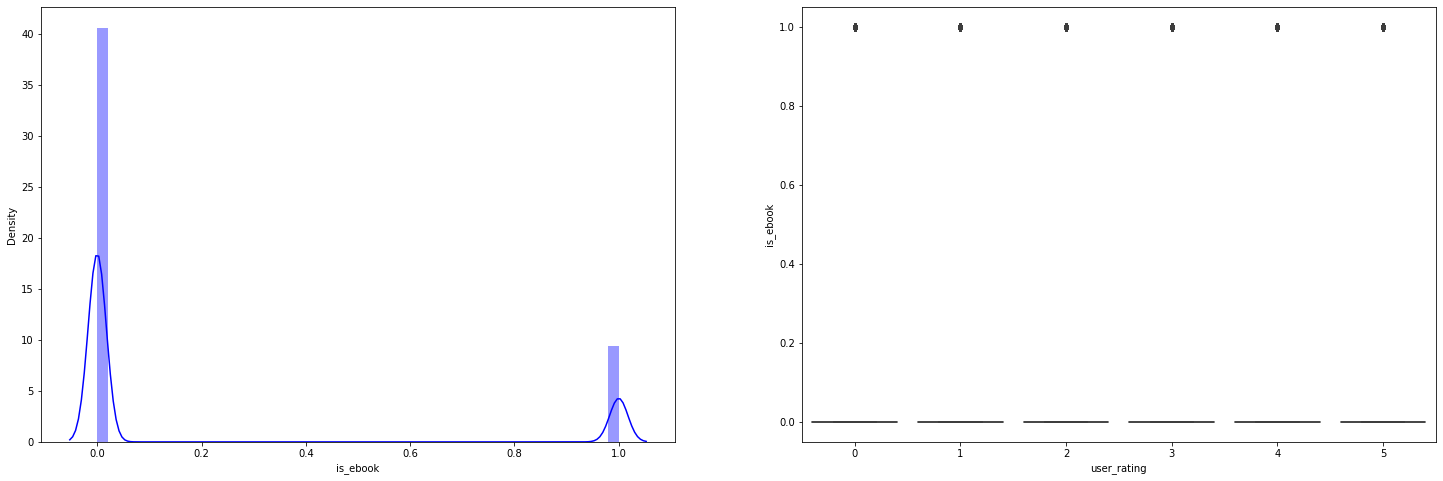

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
sns.distplot(df_books_users['is_ebook'], ax=axes[0], color='blue')
sns.boxplot(y= 'is_ebook', data=df_books_users[(df_books_users['book_average_rating']>2.6) & (df_books_users['book_average_rating']<4.8)], ax=axes[1],  x='user_rating')
plt.show()

Observation:


*   We can see that 80% of books are paper books and only 20% paper books.
*   is_ebook seems to be useful feature as it has distribution of 80-20 over two different categories, probably it will help.



### ***ratings_count***

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_users['ratings_count'], i))

0th percentile is 16.0
10th percentile is 42.0
20th percentile is 88.0
30th percentile is 174.0
40th percentile is 332.0
50th percentile is 624.0
60th percentile is 1190.0
70th percentile is 2384.0
80th percentile is 5474.0
90th percentile is 17746.0
100th percentile is 748926.0


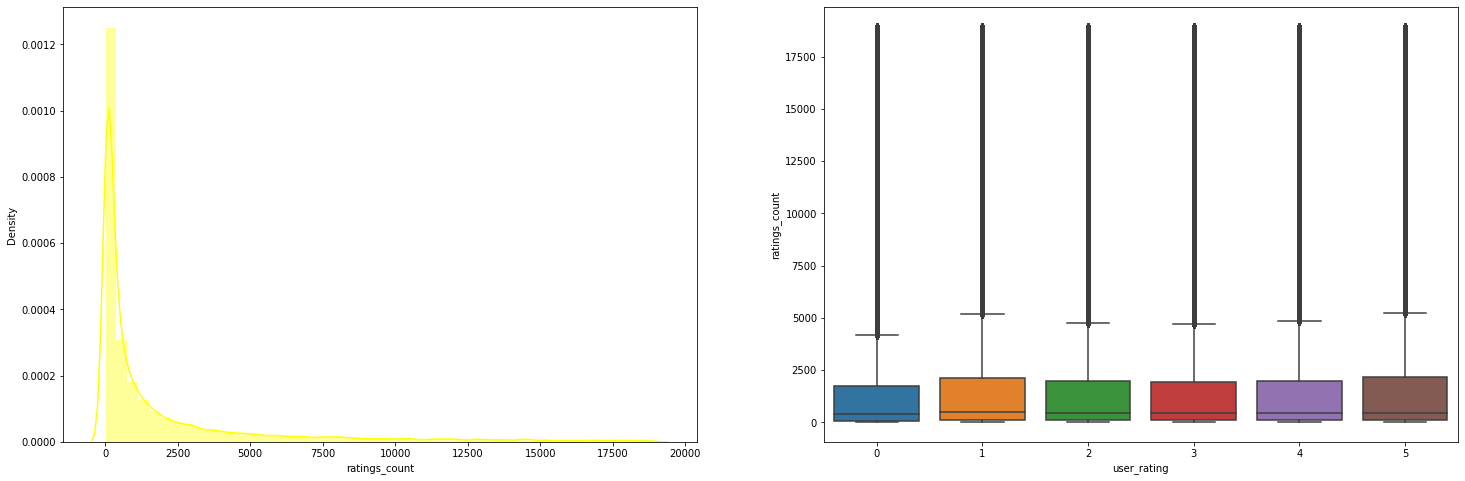

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,8))
filter_data = df_books_users[df_books_users['ratings_count']<=18935.0]
sns.distplot(filter_data['ratings_count'], ax=axes[0], color='yellow')
sns.boxplot(y= 'ratings_count', data=filter_data[(filter_data['book_average_rating']>2.6) & (filter_data['book_average_rating']<4.8)] , ax=axes[1],  x='user_rating')
plt.show()

Observation:


*   90% of books has been rated by less than 17746 users.
*   Data is distributed across all user_rating, we will keep it.



### ***Distplots and Countplots Analysis/ Conclusion***

***Distplot***

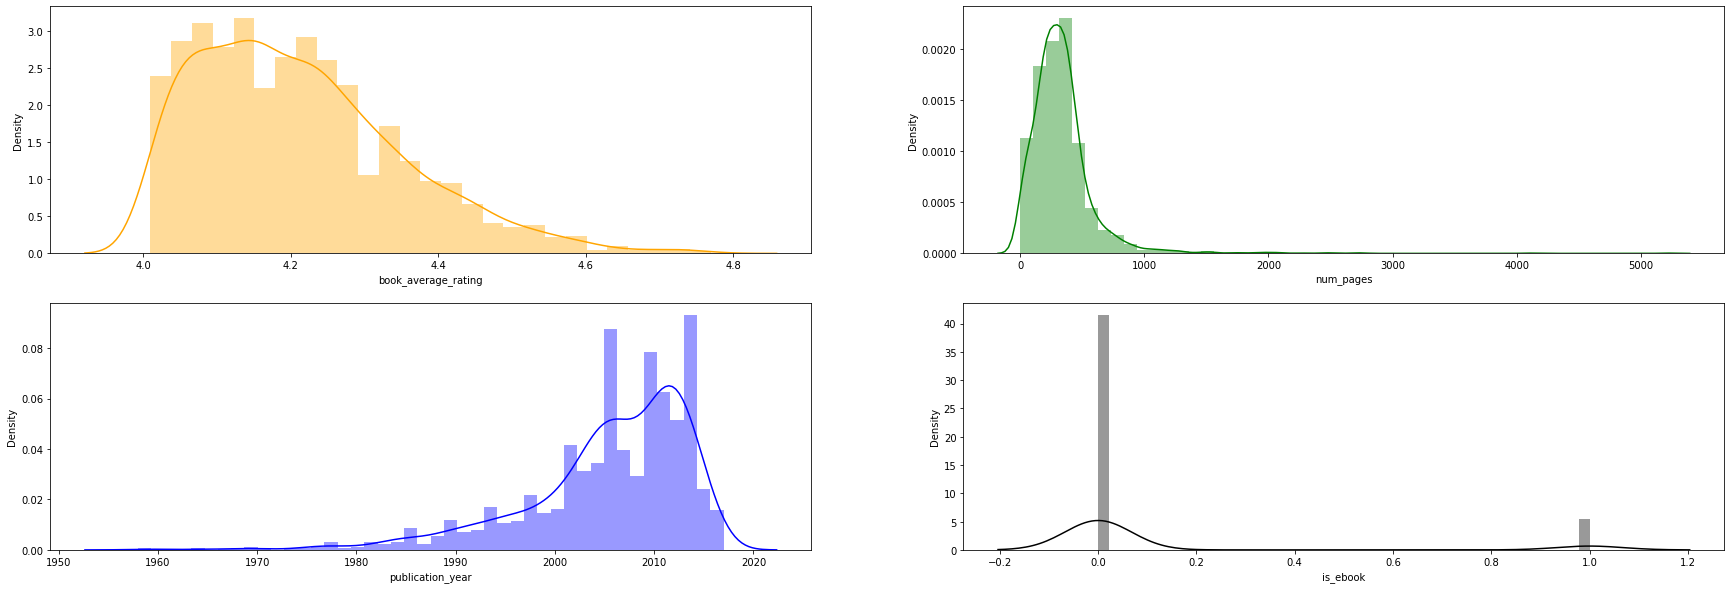

In [ ]:
filtered_dataset = df_books_processed[(df_books_processed['book_average_rating']>4.0) & (df_books_processed['ratings_count']>8000) & (df_books_processed['publication_year']>1950)]


figure, axes = plt.subplots(2, 2, figsize=(30,10))
sns.distplot(filtered_dataset['book_average_rating'], ax=axes[0,0], label='Average Rating on Books', color='orange')
sns.distplot(filtered_dataset['num_pages'], ax=axes[0,1], label='Number of Pages in Books',color="green")
sns.distplot(filtered_dataset['publication_year'], ax=axes[1,0], label='Publication Year of Books',color="blue")
sns.distplot(filtered_dataset['is_ebook'], ax=axes[1,1], label='E-Book/Paper Book',color="black")
plt.show()

***Countplots***

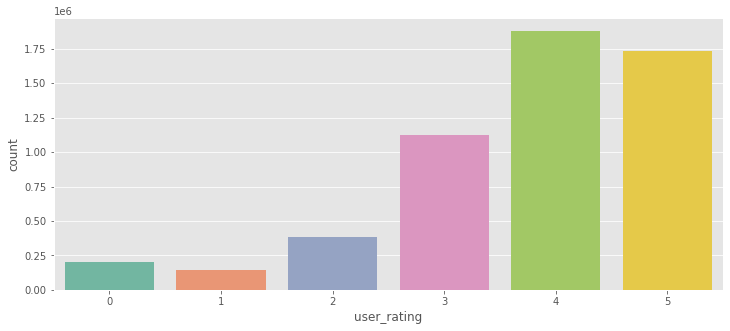

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
sns.countplot(data = df_books_users, x= 'user_rating', palette='Set2')
plt.show()

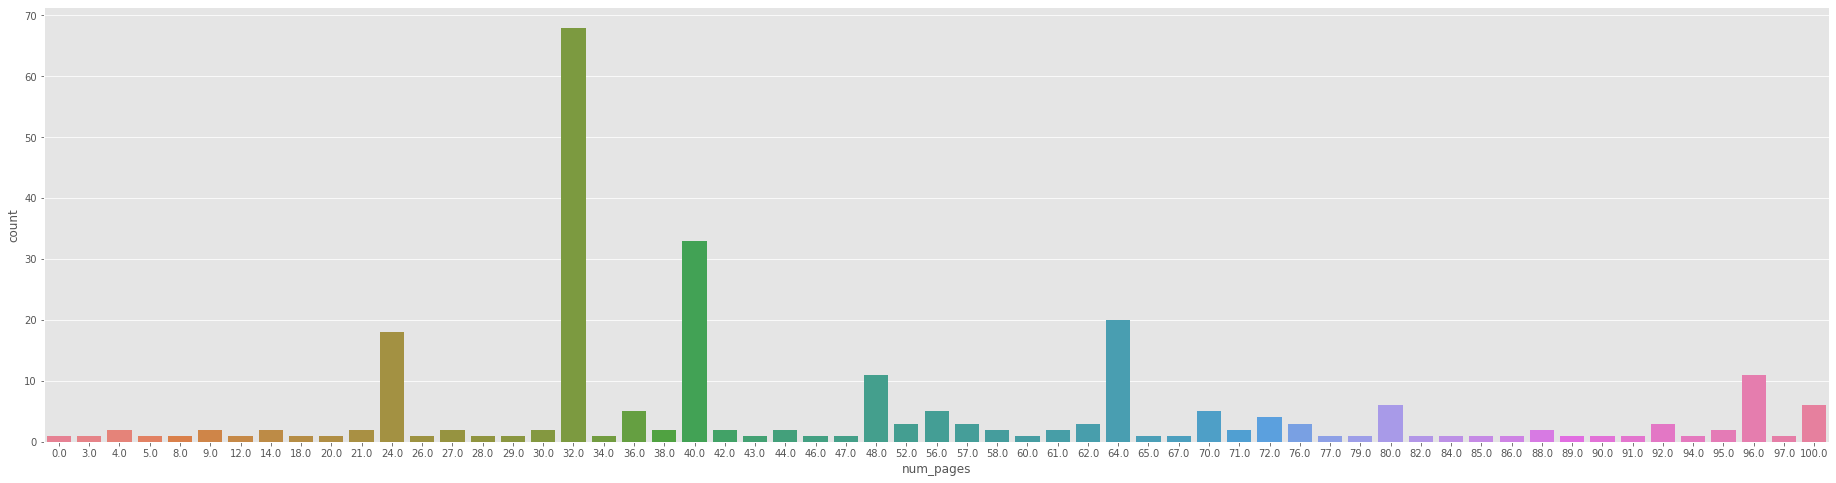

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(32, 8))
sns.countplot(data=filtered_dataset[filtered_dataset['num_pages']<=100] , x='num_pages', palette='husl')
plt.show()

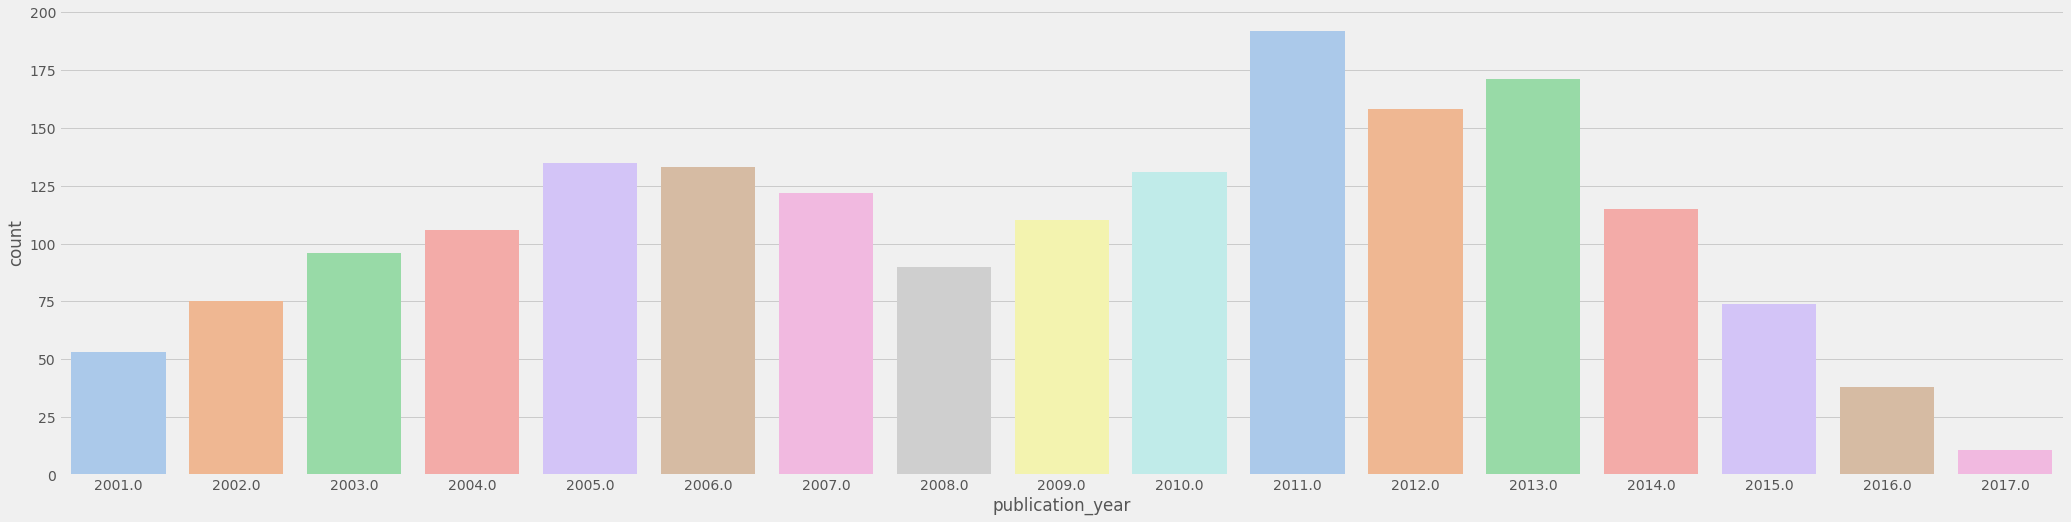

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(32, 8))
sns.countplot(data=filtered_dataset[filtered_dataset['publication_year']>2000] , x='publication_year', palette='pastel')
plt.show()

### ***Correlation Analysis between each numeric feature***

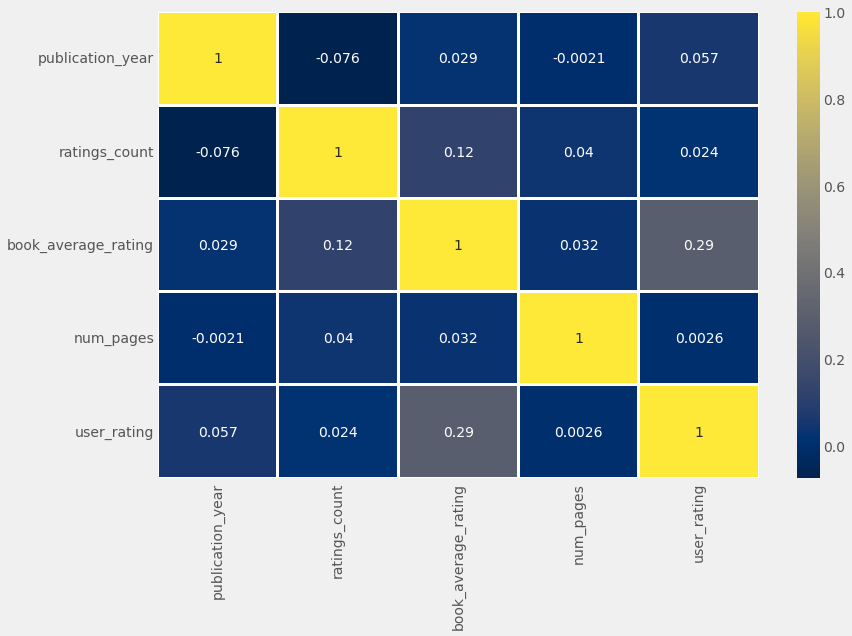

In [ ]:
cormat = df_books_users[['publication_year', 'ratings_count', 'book_average_rating', 'num_pages', 'user_rating']].corr()
round(cormat,2)
plt.figure(figsize=(12, 8))
sns.heatmap(cormat, cmap='cividis', annot=True, linewidths=2)
plt.show()

Observation:


*   If we look w.r.t to user-rating(target feature), we see that book-average is next highly correlated feature followed by publication_year, rating_count and then at last it's least correlated with num_pages in books 



***Saving df_books_users_processed dataframe***

In [ ]:
df_books_users_processed = df_books_users
df_books_users_processed.to_csv('df_books_users_processed.csv.gz', index=False, compression='gzip')

In [ ]:
df_books_users_processed.isnull().any()

book_id                 False
title_without_series    False
book_description        False
publication_year        False
publisher               False
ratings_count           False
book_average_rating     False
cover_page              False
book_url                False
is_ebook                False
num_pages               False
mod_title               False
user_id                 False
review_text             False
user_rating             False
book_id_mapped          False
publisher_mapped        False
is_ebook_mapped         False
user_id_mapped          False
dtype: bool

In [6]:
df_books_processed = pd.read_csv('/content/df_books_processed.csv.gz')
df_books_users_processed = pd.read_csv('/content/df_books_users_processed.csv.gz')

In [22]:
df_books_users_processed = df_books_users_processed.dropna(axis=0)
df_books_processed = df_books_processed[df_books_processed['mod_title'].notnull()]

Conclusion:

*   There are 2079758 books in df_users_processed and 678274 books in df_books_processed.We merged the two dataframes on 'book_id', by making inner merge.After merge operation we are remaining with only books for which we have information in  both df_books and df_users dataframe.
*   We have 3,28,596 users remaining in final dataframe, df_books_users.
*   We have 6,59,411 books in final dataframe, df_books_users.
*   We have 54,67,457  data points (users rating on books) with  15 features avaialble.

Features are: 

1.   book_id
2.   title_without_series
3.   book_description
4.   publication_year
5.   publisher
6.   ratings_count
7.   book_average_rating
8.   cover_page
9.   book_url
10.  is_ebook
11.  num_pages
12.  user_id
13.  mod_title
14.  user_rating
15.  review_text










## **First Cut Solution**

### Top 50 books with best book_average_rating

*Ratings_count*

In [ ]:
for i in range(0, 110, 10):
  print(f'{i}th percentile is', np.percentile(df_books_processed['ratings_count'], i))

0th percentile is 16.0
10th percentile is 20.0
20th percentile is 26.0
30th percentile is 34.0
40th percentile is 45.0
50th percentile is 61.0
60th percentile is 86.0
70th percentile is 131.0
80th percentile is 226.0
90th percentile is 529.0
100th percentile is 748926.0


In [ ]:
for i in range(90, 101):
  print(f'{i}th percentile is', np.percentile(df_books['ratings_count'], i))

90th percentile is 638.0
91th percentile is 729.0
92th percentile is 843.0
93th percentile is 992.0
94th percentile is 1193.0
95th percentile is 1481.0
96th percentile is 1911.7600000000093
97th percentile is 2650.0
98th percentile is 4138.0
99th percentile is 8469.0
100th percentile is 4899965.0




*   *On average 50% of books are rated by 61 users*



*These are highest rated books in among top 3% highly rated movies by users*

In [85]:
def top_book_average_rating():
  top50_highest_rated_books = df_books_processed[(df_books_processed['book_average_rating']>=4.50) & (df_books_processed['ratings_count']>3000.0)].sort_values(by='book_average_rating', ascending=False)
  top50_highest_rated_books[:50].to_csv('top50_highest_rated_books.csv', index=False)
  return top50_highest_rated_books[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

top_book_average_rating()

,book_id,title_without_series,book_average_rating,book_url,cover_page
452488,11221285,"The Way of Kings, Part 2 (The Stormlight Archive #1.2)",4.780000,Goodreads,
671973,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.770000,Goodreads,
199975,165068,The Jesus Storybook Bible: Every Story Whispers His Name,4.750000,Goodreads,
605767,24814,It's a Magical World: A Calvin and Hobbes Collection,4.750000,Goodreads,
231170,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,4.740000,Goodreads,


###Top 50 concised books


In [ ]:
df_books['num_pages'].describe()

count    937378.000000
mean        280.252306
std        1002.116670
min           0.000000
25%         170.000000
50%         263.000000
75%         356.000000
max      945077.000000
Name: num_pages, dtype: float64

In [86]:
def top_concised_books():
  top_50_concised_books = df_books_processed[(df_books_processed['num_pages']<=300)& (df_books_processed['ratings_count']>3000.0)&(df_books_processed['book_average_rating']>=4.50)].sort_values(by='book_average_rating', ascending=False)
  top_50_concised_books.to_csv('top_50_concised_books.csv', index=False)
  return top_50_concised_books[['book_id', 'title_without_series', 'num_pages', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

top_concised_books()

,book_id,title_without_series,num_pages,book_average_rating,book_url,cover_page
605767,24814,It's a Magical World: A Calvin and Hobbes Collection,176.000000,4.750000,Goodreads,
231170,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,176.000000,4.740000,Goodreads,
605768,24815,The Indispensable Calvin and Hobbes,255.000000,4.730000,Goodreads,
231171,70487,Attack of the Deranged Mutant Killer Monster Snow Goons,127.000000,4.720000,Goodreads,
107090,121792,The Revenge of the Baby-Sat,128.000000,4.710000,Goodreads,


### Top 50 e-books

*We can see that 'is_ebook' is useful feature, as among highly rated books it books that are not e-book has more percentage*

In [87]:
def top_50_paper_books():
  df_ebook = df_books_processed[(df_books_processed['book_average_rating']>=4.5) & (df_books_processed['ratings_count']>3000.0)].sort_values(by='book_average_rating', ascending=False)
  top_50_paper_books = df_ebook[df_ebook['is_ebook']==False]
  top_50_paper_books.to_csv('top_50_paper_books.csv', index=False)
  return top_50_paper_books[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

top_50_paper_books()

,book_id,title_without_series,book_average_rating,book_url,cover_page
452488,11221285,"The Way of Kings, Part 2 (The Stormlight Archive #1.2)",4.780000,Goodreads,
671973,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.770000,Goodreads,
199975,165068,The Jesus Storybook Bible: Every Story Whispers His Name,4.750000,Goodreads,
605767,24814,It's a Magical World: A Calvin and Hobbes Collection,4.750000,Goodreads,
231170,70489,There's Treasure Everywhere: A Calvin and Hobbes Collection,4.740000,Goodreads,


###  Books having similar book title 

In [ ]:
vectorizer_title_fc = TfidfVectorizer()
tfidf_title_fc = vectorizer_title_fc.fit_transform(df_books_processed["mod_title"])

In [ ]:
with open('/content/vectorizer_title.pkl', 'wb') as p:
    dump(vectorizer_title_fc, p)

with open('/content/tfidf_title.pkl', 'wb') as p:
    dump(tfidf_title_fc, p)    

with open("/content/vectorizer_title.pkl", "rb") as p:
    vectorizer_title_fc = load(p)    

with open("/content/tfidf_title.pkl", "rb") as p:
    tfidf_title_fc = load(p)       

In [ ]:
def top_50_similar_title_books(vectorizer):
  query = str(input('Enter book title: '))
  processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
  query_vec = vectorizer.transform([query])
  similarity = cosine_similarity(query_vec, tfidf_title_fc).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  results = df_books_processed.iloc[indices]
  return results[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

top_50_similar_title_books(vectorizer_title_fc) 

Enter book title: Ms. Marvel


,book_id,title_without_series,book_average_rating,book_url,cover_page
489373,25747529,"Ms. Marvel, #16: Last Days, Part I",4.350000,Goodreads,
1307103,31835461,"Ms. Marvel, #13: Election Day",3.810000,Goodreads,
710722,30734747,"Ms. Marvel, #11: Civil War II",4.370000,Goodreads,
1106921,27862864,"Ms. Marvel, #3: Super Famous, Part 3",4.260000,Goodreads,
361167,26129284,"Ms. Marvel, #1: Super Famous, Part 1",4.250000,Goodreads,


### Books having similar description

In [ ]:
vectorizer_description = TfidfVectorizer()
tfidf_description = vectorizer_description.fit_transform(df_books_processed["book_description"])

In [ ]:
with open('/content/vectorizer_description.pkl', 'wb') as p:
    dump(vectorizer_description, p)

with open('/content/tfidf_description.pkl', 'wb') as p:
    dump(tfidf_description, p)    

with open("/content/vectorizer_description.pkl", "rb") as p:
    vectorizer_description = load(p)    

with open("/content/tfidf_description.pkl", "rb") as p:
    tfidf_description = load(p)

In [ ]:
def search(vectorizer):
  query = str(input('Enter the Description: '))
  processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
  query_vec = vectorizer.transform([query])
  similarity = cosine_similarity(query_vec, tfidf_description).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  results = df_books_processed.iloc[indices]
  return results[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})
  
search(vectorizer_description) 

Enter the Description: who is the inventor and what does he want with the allnew ms marvel and all her friends maybe wolverine can help if kamala can stop fangirling out about meeting her favorite super hero that is then kamala crosses paths with inhumanity by meeting the royal dog lockjaw but why is lockjaw really with kamala as ms marvel discovers more about her past the inventor continues to threaten her future kamala bands together with some unlikely heroes to stop the maniacal villain before he does real damage but has she taken on more than she can handle and how much longer can ms marvels life take over kamala khans kamala khan continues to prove why shes the best and most adorable new super hero there iscollecting ms marvel2014 611


,book_id,title_without_series,book_average_rating,book_url,cover_page
812935,18485268,Wages of Love,4.160000,Goodreads,
344792,1329445,"Ms. Marvel, Volume 3: Operation Lightning Storm",3.550000,Goodreads,
1069146,1104246,Naming Maya,3.470000,Goodreads,
655167,34612997,"Ms. Marvel, Vol. 3: Apaixonada",4.210000,Goodreads,
828991,26030938,A-Force Presents Vol. 3,3.670000,Goodreads,


### Books that got similar review

In [ ]:
data = list()
for book_id, df in tqdm(df_users[['book_id', 'review_text']].groupby('book_id')):
  data.append((book_id, list(df['review_text'])))

df_book_id_review = pd.DataFrame(data, columns =['book_id', 'list_review_text'])
df_book_id_review  

100%|██████████| 2079758/2079758 [03:41<00:00, 9399.52it/s] 


,book_id,list_review_text
0,1,"[One of the best books in the series I think.,..."
1,10,"[good read, LOVED the Harry Potter books!, Har..."
2,100,[Some ideas were pretty fun and original!]
3,1000,"[There's a lot in this book that I enjoyed, be..."
4,10000,[This has not aged well. Of course I have only...
...,...,...
2079753,9999954,"[Dat zo'n Dijkshoorn op tv nog te pruimen is, ..."
2079754,9999969,[Over all a fun read. Every one of the stories...
2079755,9999986,"[Picking up ""Walking to the Stars,"" I didn't k..."
2079756,999999,[Fantastic]


In [ ]:
df_final_review = df_book_id_review[df_book_id_review['book_id'].isin(set(df_books_processed['book_id']))]
df_final_review.reset_index(drop=True, inplace=True)

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
preprocessed_reviews = list()
for sentences in tqdm(df_final_review['list_review_text'].values):
  mod_sentences = list()
  for sentence in sentences:
    try:
      sentence = re.sub(r"http\S+", "", sentence)
      sentence = decontracted(sentence)
      sentence = re.sub('[^A-Za-z]+', ' ', sentence[:500])
      sentence = BeautifulSoup(sentence, 'lxml').get_text()
     
      sentence = re.sub("\S*\d\S*", "", sentence).strip()
      sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
      mod_sentences.append(sentence.strip()) 
    except Exception:
      pass 
  preprocessed_reviews.append(mod_sentences)     

100%|██████████| 662171/662171 [28:39<00:00, 385.17it/s]


In [ ]:
review = [' '.join(lst) for lst in tqdm(preprocessed_reviews)]

100%|██████████| 662171/662171 [00:02<00:00, 297996.63it/s]


In [ ]:
df_final_review['combined_processed_review'] = review
df_final_review['preprocessed_reviews'] = preprocessed_reviews

In [ ]:
vectorizer_review = TfidfVectorizer()
tfidf_review = vectorizer_review.fit_transform(df_final_review['combined_processed_review'])

In [ ]:
with open('/content/vectorizer_review.pkl', 'wb') as p:
    dump(vectorizer_review, p)

with open('/content/tfidf_review.pkl', 'wb') as p:
    dump(tfidf_review, p)    

with open("/content/vectorizer_review.pkl", "rb") as p:
    vectorizer_review = load(p)    

with open("/content/tfidf_review.pkl", "rb") as p:
    tfidf_review = load(p)

In [ ]:
df_final_review.to_csv('df_final_review.csv.gz', compression='gzip', index=False)

In [ ]:
def review_similarity():
  book_id = (input('Enter the book_id: '))
  index = df_final_review[df_final_review['book_id']== book_id].index
  similarity = cosine_similarity(tfidf_review[index], tfidf_review).flatten()
  indices = np.argpartition(similarity, -50)[-50:]
  book_ids = set(df_final_review.iloc[indices]['book_id'])
  score = [(score, book) for score, book in enumerate(book_ids)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id'])
  results = (df_books_processed[df_books_processed['book_id'].isin(book_ids)].merge(df_score, on='book_id')).sort_values(by='score')
  print('Entered book title: ', str(df_books_processed[df_books_processed['book_id']==(book_id)]['title_without_series'].values[0]).strip())
  return results[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page', 'ratings_count']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})
  
review_similarity() 

Enter the book_id: 23017947
Entered book title:  Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,book_average_rating,book_url,cover_page,ratings_count
7,24501973,S.H.I.E.L.D. #2,3.860000,Goodreads,,102
13,22558777,"Ms. Marvel, #8: Generation Why",4.360000,Goodreads,,761
25,31279293,"Ms. Marvel, #12: The Road to War",4.340000,Goodreads,,100
16,305771,"Essential Wolverine, Vol. 2",4.130000,Goodreads,,315
15,26129284,"Ms. Marvel, #1: Super Famous, Part 1",4.250000,Goodreads,,443


### Books where user choice's match

In [ ]:
def similar_user_df(df_books_users):
  user_id = str(input("Enter the user_id: "))
  df_liked_books = df_books_users[df_books_users['user_id']==user_id]
  liked_books = set(df_liked_books['book_id'])
  top_5_liked_books = df_liked_books.sort_values(by='user_rating', ascending=False)['book_id'][:5]
  similar_user = df_books_users[(df_books_users['book_id'].isin(top_5_liked_books))& (df_books_users['user_rating']>4)]['user_id']
  data = df_books_users[(df_books_users['user_id'].isin(similar_user))][['user_id', 'book_id', 'user_rating', 'ratings_count','title_without_series', 'book_average_rating', 'book_url', 'cover_page']]
  return data, liked_books        

def popular_recommendation(recs, liked_books):
  all_recs = recs["book_id"].value_counts()
  all_recs = all_recs.to_frame().reset_index()
  all_recs.columns = ["book_id", "book_count"]
  all_recs = all_recs.merge(recs, how="inner", on="book_id")
  all_recs["score"] = all_recs["book_count"] * (all_recs["book_count"] / all_recs["ratings_count"])
  popular_recs = all_recs.sort_values("score", ascending=False)
  popular_recs_unbiased = popular_recs[~popular_recs["book_id"].isin(liked_books)].drop_duplicates(subset=['title_without_series'])
  popular_recs_unbiased.to_csv('popular_recs.csv', index=False)
  return popular_recs_unbiased[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page', 'ratings_count']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

recs, liked_books = similar_user_df(df_books_users)
popular_recommendation(recs, liked_books)

Enter the user_id: fcddf0227aafbf744a7714ac4409d373


,book_id,title_without_series,book_average_rating,book_url,cover_page,ratings_count
653,23017947,"Ms. Marvel, Vol. 2: Generation Why",4.140000,Goodreads,,17597
1200,23546843,"Ms. Marvel, Vol. 3: Crushed",4.210000,Goodreads,,13311
1738,25066780,"Ms. Marvel, Vol. 4: Last Days",4.250000,Goodreads,,9604
35604,16002160,Marvel Masterworks: Captain Marvel - Volume 1,3.230000,Goodreads,,16
2419,27163013,"Ms. Marvel, Vol. 5: Super Famous",4.240000,Goodreads,,6471


## **Similiar Cover-Image of Books**

***Filtering out books that have missing cover pages***

In [ ]:
df_books_with_cover_page = df_books_processed[~df_books_processed['cover_page'].str.contains("https://s.gr-assets.com/assets/nophoto")]

***Saving images from provided book's cover page url***

In [ ]:
def firstprocess():
  for index, row in (df_books_with_cover_page[:59601].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/folderone_image/'+ str(row['book_id'])+'.jpeg')
    except Exception:
      pass
      
def secondprocess():
  for index, row in (df_books_with_cover_page[59601:119202].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/foldertwo_image/'+ str(row['book_id'])+'.jpeg')
    except Exception:
      pass
        
def thirdprocess():
  for index, row in (df_books_with_cover_page[119202:178803].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/folderthree_image/'+ str(row['book_id'])+'.jpeg') 
    except Exception:
      pass

def fourthprocess():
  for index, row in (df_books_with_cover_page[178803:238404].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/folderfour_image/'+ str(row['book_id'])+'.jpeg')
    except Exception:
      pass
     
def fifthprocess():
  for index, row in (df_books_with_cover_page[238404:298005].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/folderfive_image/'+ str(row['book_id'])+'.jpeg') 
    except Exception:
      pass
     
def sixthprocess():
  for index, row in (df_books_with_cover_page[298005:357606].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/foldersix_image/'+ str(row['book_id'])+'.jpeg')
    except Exception:
      pass
      
def seventhprocess():
  for index, row in (df_books_with_cover_page[357606:417207].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/folderseven_image/'+ str(row['book_id'])+'.jpeg')
    except Exception:
      pass      

def eigthprocess():
  for index, row in (df_books_with_cover_page[417207:476815].iterrows()):
    url = row['cover_page']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
          img = img.convert('RGB')
        img.save('/content/foldereight_image/'+ str(row['book_id'])+'.jpeg') 
    except Exception:
      pass                                     

***Multiprocessing for parallelizing jobs***

In [ ]:
from multiprocessing import Process

def main():	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    p5=Process(target=fifthprocess)
    p6=Process(target=sixthprocess)
    p7=Process(target=seventhprocess)
    p8=Process(target=eigthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    p6.start()
    p7.start()
    p8.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()

if __name__=="__main__":
    main()

Observation:


*   Above code took nearly 90 minutes on TPU



***Transfer Learning(VGG16): Extracting feature vectors from saved cover page of books***

In [ ]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(95, 140, 3))
model_new = Model(model_vgg16.input, model_vgg16.layers[-1].output)

def firstprocess():
  mapper = dict()
  folderone_image = os.listdir('/content/folderone_image')
  for image_path in tqdm(folderone_image):
    image = load_img('/content/folderone_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[int(image_path.split('.')[0])] = bottleneck_features_train
  with open('/content/folderone_image.pkl', 'wb') as p:
      dump(mapper, p)  

def secondprocess():
  mapper = dict()
  foldertwo_image = os.listdir('/content/foldertwo_image')
  for image_path in tqdm(foldertwo_image):
    image = load_img('/content/foldertwo_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/foldertwo_image.pkl', 'wb') as p:
      dump(mapper, p)

def thirdprocess():
  mapper = dict()
  folderthree_image = os.listdir('/content/folderthree_image')
  for image_path in tqdm(folderthree_image):
    image = load_img('/content/folderthree_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/folderthree_image.pkl', 'wb') as p:
      dump(mapper, p)

def fourthprocess():
  mapper = dict()
  folderfour_image = os.listdir('/content/folderfour_image')
  for image_path in tqdm(folderfour_image):
    image = load_img('/content/folderfour_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/folderfour_image.pkl', 'wb') as p:
      dump(mapper, p)

def fifthprocess():
  mapper = dict()
  folderfive_image = os.listdir('/content/folderfive_image')
  for image_path in tqdm(folderfive_image):
    image = load_img('/content/folderfive_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/folderfive_image.pkl', 'wb') as p:
      dump(mapper, p)


def sixthprocess():
  mapper = dict()
  foldersix_image = os.listdir('/content/foldersix_image')
  for image_path in tqdm(foldersix_image):
    image = load_img('/content/foldersix_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/foldersix_image.pkl', 'wb') as p:
      dump(mapper, p)


def seventhprocess():
  mapper = dict()
  folderseven_image = os.listdir('/content/folderseven_image')
  for image_path in tqdm(folderseven_image):
    image = load_img('/content/folderseven_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/folderseven_image.pkl', 'wb') as p:
      dump(mapper, p)


def eigthprocess():
  mapper = dict()
  foldereight_image = os.listdir('/content/foldereight_image')
  for image_path in tqdm(foldereight_image):
    image = load_img('/content/foldereight_image/'+image_path, target_size=(95, 140))
    image = img_to_array(image)
    image = preprocess_input(image)
    bottleneck_features_train = np.array(model_new(np.expand_dims(image, axis=0))).flatten()
    mapper[image_path.split('.')[0]] = bottleneck_features_train

  with open('/content/foldereight_image.pkl', 'wb') as p:
      dump(mapper, p)

firstprocess()
secondprocess()
thirdprocess()
fourthprocess()
fifthprocess()
sixthprocess()
seventhprocess()
eigthprocess()      

Observation:


*   Each function created above took nearly 6 min on GPU(6*8=48 minutes)



***Loading saved features***

In [ ]:
mapper1 = load(open("/content/folderone_image.pkl", "rb"))
mapper2 = load(open("/content/foldertwo_image.pkl", "rb"))
mapper3 = load(open("/content/folderthree_image.pkl", "rb"))
mapper4 = load(open("/content/folderfour_image.pkl", "rb"))
mapper5 = load(open("/content/folderfive_image.pkl", "rb"))
mapper6 = load(open("/content/foldersix_image.pkl", "rb"))
mapper7 = load(open("/content/folderseven_image.pkl", "rb"))
mapper8 = load(open("/content/foldereight_image.pkl", "rb"))

***Translating features vector dimensions***



*   Note: This part can be taken care while extracting features through Transfer Learning

In [ ]:
mapper1 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper1.items()))
mapper2 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper2.items()))
mapper3 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper3.items()))
mapper4 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper4.items()))
mapper5 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper5.items()))
mapper6 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper6.items()))
mapper7 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper7.items()))
mapper8 = dict(map(lambda x: (x[0], x[1].reshape(1, -1)), mapper8.items()))

***Merging all dictionaries, creating dataframe***

In [ ]:
merge = {**mapper1, **mapper2, **mapper3, **mapper4, **mapper5, **mapper6, **mapper7, **mapper8}
df_image = pd.DataFrame(list(merge.items()), columns=['book_id', 'features'])
features = np.squeeze(np.array(list(df_image['features'])), axis=1)
df_image['book_id'] = df_image['book_id'].astype(int)

In [ ]:
def get_similar_books_cnn():
  book_id = int(input('Enter the book_id: '))
  index = df_image[df_image['book_id']== book_id].index
  pairwise_dist = pairwise_distances(features, features[index].reshape(1,-1), metric='cosine')
  indices = list(np.argsort(pairwise_dist.flatten())[0:5])
  book_ids = list(df_image.loc[indices]['book_id'])
  score = [(score, book) for score, book in enumerate(book_ids)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id'])
  similar_books= (df_books_processed[df_books_processed['book_id'].isin(book_ids)].merge(df_score, on='book_id')).sort_values(by='score')
  print('Entered book title: ', str(df_books_processed[df_books_processed['book_id']==int(book_id)]['title_without_series'].values[0]).strip())
  return similar_books[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

get_similar_books_cnn()

Enter the book_id: 23017947
Entered book title:  Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,book_average_rating,book_url,cover_page
2,23017947,"Ms. Marvel, Vol. 2: Generation Why",4.140000,Goodreads,
0,27251104,"Ms. Marvel, Vol. 2: Génération Y",4.140000,Goodreads,
1,22558726,"Ms. Marvel, #6: Healing Factor",4.440000,Goodreads,
3,31121362,"Ms. Marvel, Vol. 2: Questões Mil",4.140000,Goodreads,
4,5071490,"Fairy Tail, Vol. 06 (Fairy Tail, #6)",4.450000,Goodreads,


## **Correlation-Based Recommendation**

In [ ]:
user = df_books_users_processed['user_id'].value_counts().to_frame().reset_index()
user.columns = ['user_id', 'user_rating_count']
highly_active_users = user[user['user_rating_count']>300]['user_id']
highly_rated_books = df_books_processed[df_books_processed['ratings_count']>3000]['book_id']

In [ ]:
def correlation_recommendation():
  confined_df_users_books = df_books_users_processed[(df_books_users_processed['user_id'].isin(highly_active_users)) & (df_books_users_processed['book_id'].isin(highly_rated_books))]
  confined_df_users_books_limited  = confined_df_users_books[['user_id', 'book_id', 'user_rating']]
  pivot_books = confined_df_users_books_limited.pivot(index='user_id', columns='book_id').user_rating
  book_id = int(input('Enter the book_id: '))
  pivot_book_id = pivot_books[book_id]
  scores = pivot_books.corrwith(pivot_book_id).to_frame().reset_index()
  scores.columns = ['book_id', 'pearson_score']
  scores.dropna(inplace=True)
  similar_books_to_given_book = (df_books_processed[df_books_processed['book_id'].isin(scores[scores['pearson_score']>0.0]['book_id'])].merge(scores[scores['pearson_score']>0.0], on='book_id')).sort_values(by='pearson_score', ascending=False)
  print('Title of book given by customer:', str(df_books_processed[df_books_processed['book_id']==book_id]['title_without_series'].values[0]).strip())
  return similar_books_to_given_book[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

correlation_recommendation()  

Enter the book_id: 23017947
Title of book given by customer: Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,book_average_rating,book_url,cover_page
755,148875,"The Rising Force (Star Wars: Jedi Apprentice, #1)",3.850000,Goodreads,
576,9647908,"The Ideal Man (Buchanan-Renard, #9)",3.920000,Goodreads,
541,11889938,"Taken (Elvis Cole, #15; Joe Pike, #4)",4.170000,Goodreads,
530,3710603,Y: The Last Man - The Deluxe Edition Book One,4.360000,Goodreads,
528,16061340,"The Colossus Rises (Seven Wonders, #1)",3.840000,Goodreads,



## **Content Based Filtering** 

*Finding Tf-idf score for mod_title*

In [25]:
vectorizer_title = TfidfVectorizer(max_df= 659408, min_df= 100,  stop_words='english')
vectorizer_title.fit(df_books_processed["mod_title"])
tfidf_title = vectorizer_title.transform(df_books_users_processed['mod_title'])
tfidf_title.shape

(5422294, 3808)

*Cleaning review_text data*

In [ ]:
def processing(review):
  sentence = re.sub(r"http\S+", "", review)
  sentence = decontracted(sentence)
  sentence = re.sub('[^A-Za-z]+', ' ', sentence[:500])
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
  sentence = re.sub("\S*\d\S*", "", sentence).strip()
  sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
  return sentence

df_books_users_processed['review_text'] = df_books_users_processed['review_text'].apply(processing)

*Finding Tf-idf score for review_text*

In [26]:
vectorizer_review = TfidfVectorizer(max_df= 659408, min_df= 500, stop_words='english')
vectorizer_review.fit(df_books_users_processed["review_text"])
tfidf_review = vectorizer_review.transform(df_books_users_processed['review_text'])
tfidf_review.shape

(5422294, 19320)

*Saving necessary data*

In [27]:
with open('/content/tfidf_title.pkl', 'wb') as p:
    dump(tfidf_title, p)
with open('/content/vectorizer_title.pkl', 'wb') as p:
    dump(vectorizer_title, p)

with open('/content/tfidf_review.pkl', 'wb') as p:
    dump(tfidf_review, p)
with open('/content/vectorizer_review.pkl', 'wb') as p:
    dump(vectorizer_review, p)

*Label Encoding categorical features*

In [18]:
le1 = preprocessing.LabelEncoder()
le1.fit(df_books_users_processed['book_id'])
df_books_users_processed['book_id_mapped'] = le1.transform(df_books_users_processed['book_id'])

le4 = preprocessing.LabelEncoder()
le4.fit(df_books_users_processed['publisher'])
df_books_users_processed['publisher_mapped'] = le4.transform(df_books_users_processed['publisher'])

le7 = preprocessing.LabelEncoder()
le7.fit(df_books_users_processed['is_ebook'])
df_books_users_processed['is_ebook_mapped'] = le7.transform(df_books_users_processed['is_ebook'])

le9 = preprocessing.LabelEncoder()
le9.fit(df_books_users_processed['user_id'])
df_books_users_processed['user_id_mapped'] = le9.transform(df_books_users_processed['user_id'])

*Saving necessary data*


In [28]:
with open('/content/le1.pkl', 'wb') as p:
    dump(le1, p)
with open('/content/le4.pkl', 'wb') as p:
    dump(le4, p)
with open('/content/le7.pkl', 'wb') as p:
    dump(le7, p)
with open('/content/le9.pkl', 'wb') as p:
    dump(le9, p)             

In [ ]:
df_books_users_processed.to_csv('df_books_users_processed.csv.gz', index=False, compression='gzip')

*Extracting useful features for model training*

In [29]:
df_books_users_numeric = df_books_users_processed[['book_id_mapped', 'publisher_mapped', 'is_ebook_mapped', 'user_id_mapped', 'publication_year', 'ratings_count', 'book_average_rating', 'num_pages', 'user_rating']]

*Input and Output data for model training*

In [30]:
x = df_books_users_numeric.drop(columns=['user_rating'])
user_rating = df_books_users_numeric['user_rating']

*Normalizing Data*

In [31]:
norm = MinMaxScaler()
norm.fit(x)
x_normalized = norm.transform(x)

In [32]:
with open("/content/norm.pkl", "wb") as p:
    dump(norm, p)   

*Stacking all features*

In [33]:
data_x = hstack((x_normalized, tfidf_title, tfidf_review))

*Saving the prepared training dataset*

In [35]:
scipy.sparse.save_npz('/content/data_x.npz', data_x)
with open('/content/user_rating.pkl', 'wb') as p:
    dump(user_rating, p)

*Loading the dataset*

In [ ]:
data_x = scipy.sparse.load_npz('/content/data_x.npz')
with open("/content/user_rating.pkl", "rb") as p:
    user_rating = load(p)  

*Train-Test split*

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_x, user_rating, test_size=0.30, random_state=42)

***GridSearch on Logistic regression to find best suited parameters for model***

In [59]:
lr = OneVsRestClassifier(LogisticRegression())
param_grid = {'estimator__penalty':['l1','l2'],'estimator__class_weight':[None, 'balanced']}
gs_lr = GridSearchCV(lr, param_grid, cv= 2, scoring='f1_macro', verbose=2, return_train_score=True, n_jobs=-1)
gs_lr.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': [None, 'balanced'],
                         'estimator__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1_macro', verbose=2)

*Finding best parameters for model*

In [60]:
best_params = gs_lr.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'estimator__class_weight': None, 'estimator__penalty': 'l2'}


*Training model with best obtained Parameters*

In [37]:
clf_lr = OneVsRestClassifier(LogisticRegression())
clf_lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

*Evaluating scores obtained on trained model*

In [38]:
original = y_train   
predicted = clf_lr.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.5273979916514735

In [39]:
original = y_test   
predicted = clf_lr.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.5135025202751425

*Confusion Matrix for Precision Score*

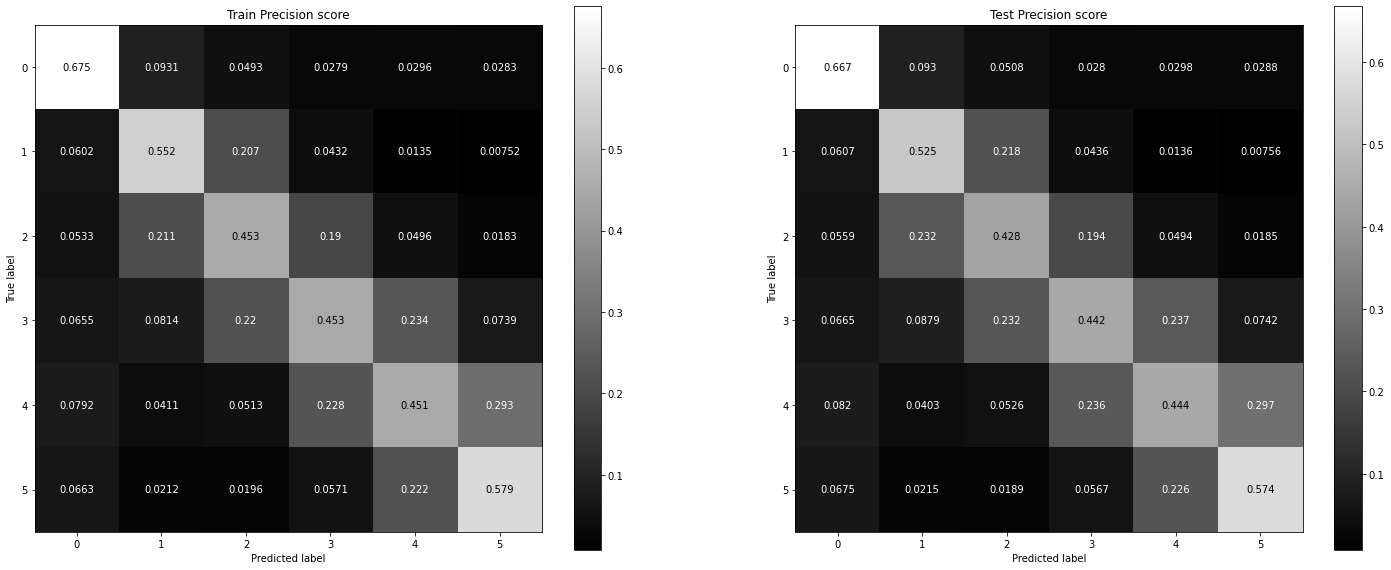

In [40]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_lr, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_lr, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

In [81]:
with open('/content/clf_lr.pkl', 'wb') as p:
    dump(clf_lr, p)

***GridSearch on DecisionTree to find best suited parameters for model***

In [ ]:
clf = DecisionTreeClassifier()
parameters = {'max_depth':[15, 17],'min_samples_split':[20]}
clf1 = GridSearchCV(clf, parameters, cv= 2, scoring='f1_macro', verbose=2, return_train_score=True, n_jobs=-1)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_split': [20]},
             return_train_score=True, scoring='f1_macro', verbose=2)

*Finding best parameters for model*

In [ ]:
best_params = clf1.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'max_depth': 20, 'min_samples_split': 20}


*Training model with best obtained Parameters*

In [41]:
clf_best = DecisionTreeClassifier(max_depth=20, min_samples_split=20)
clf_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_split=20)

*Evaluating scores obtained on trained model*

In [42]:
original = y_train   # max_depth=20, min_samples_split=20
predicted = clf_best.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.5175566440366828

In [43]:
original = y_test   # max_depth=20, min_samples_split=20
predicted = clf_best.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.45547828856406075

*Confusion Matrix for Precision Score*

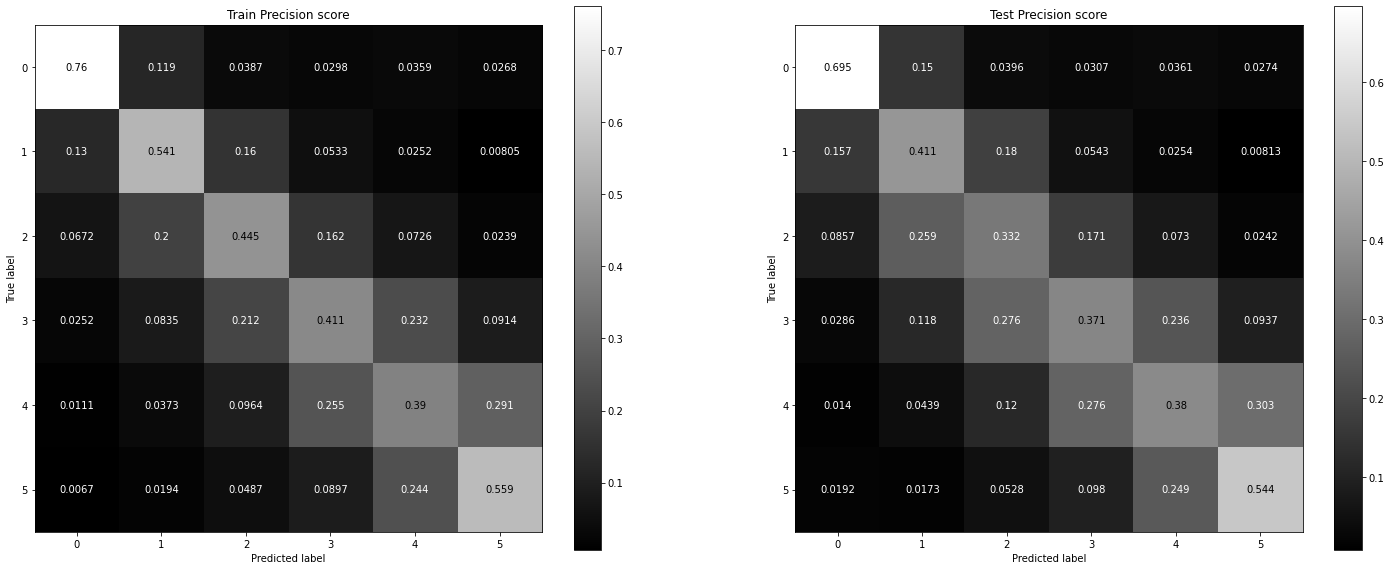

In [44]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_best, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_best, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

***GridSearch on RandomForest to find best suited parameters for model***

In [ ]:
clf = RandomForestClassifier()
parameters = {'max_depth':[15],'min_samples_split':[20, 25]}
clf1 = GridSearchCV(clf, parameters, cv= 2, scoring='f1_macro', verbose=2, return_train_score=True, n_jobs=-1)
clf1.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15], 'min_samples_split': [20, 25]},
             return_train_score=True, scoring='f1_macro', verbose=2)

*Evaluating scores and best parameters for model*

In [ ]:
bestScore = clf1.best_score_
best_params = clf1.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'max_depth': 15, 'min_samples_split': 25}


*Training model with best obtained Parameters*

In [ ]:
clf_best_rf = RandomForestClassifier(max_depth=15, min_samples_split=25)
clf_best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=25)

*Finding Score of trained model*

In [ ]:
original = y_train   # max_depth=15, min_samples_split=20
predicted = clf_best_rf.predict(X_train.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.2561621638240441

In [ ]:
original = y_test   # max_depth=15, min_samples_split=20
predicted = clf_best_rf.predict(X_test.tocsr())
score = precision_score(original, predicted, average='macro')
score

0.27420091170709243

*Confusion Matrix for Precision Score*

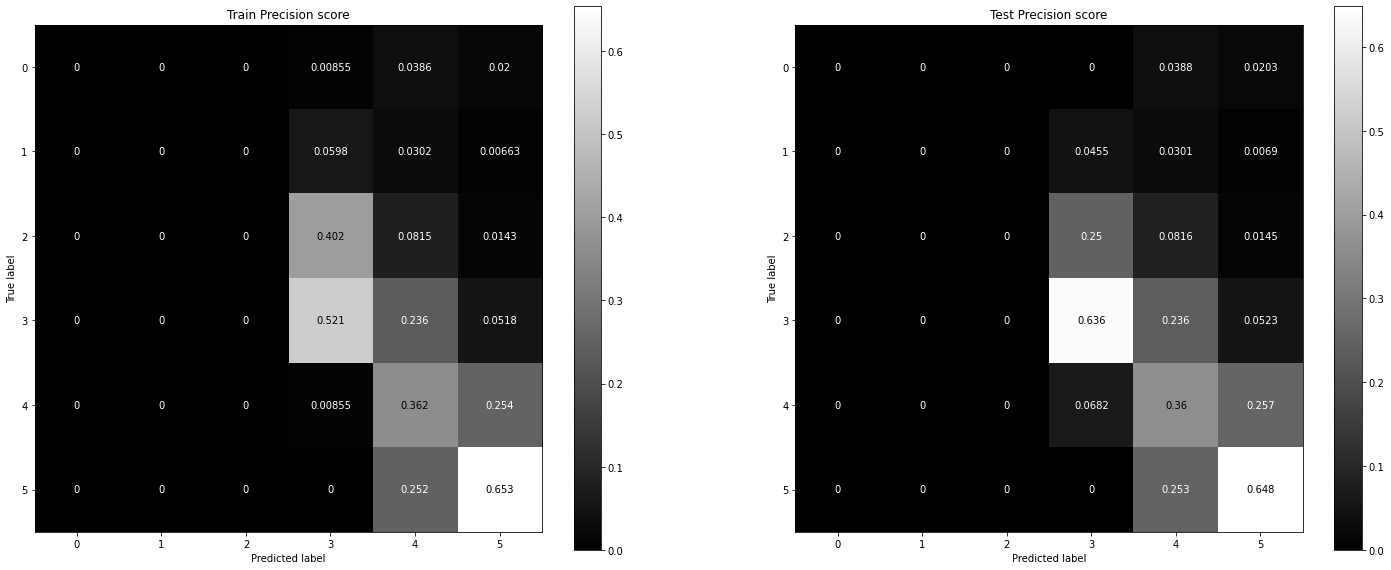

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(25,10))
plot_confusion_matrix(clf_best_rf, X_train, y_train, values_format='.3g', ax=axes[0], normalize='pred', cmap='gist_gray')  
plot_confusion_matrix(clf_best_rf, X_test, y_test, values_format='.3g', ax=axes[1], normalize='pred', cmap='gist_gray') 
axes[0].set_title('Train Precision score')
axes[1].set_title('Test Precision score') 
plt.show()

***Regression Algorithm***

In [ ]:
regressor = DecisionTreeRegressor()
parameters = {'max_depth':[15, 20, 30],'min_samples_split':[20, 23, 25]}
regressor1 = GridSearchCV(regressor, parameters, cv= 2, scoring='neg_root_mean_squared_error', verbose=2, return_train_score=True, n_jobs=-1)
regressor1.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 30],
                         'min_samples_split': [20, 23, 25]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [ ]:
best_params = regressor1.best_params_
print('Best parameters are: ', best_params)

Best parameters are:  {'max_depth': 15, 'min_samples_split': 25}


In [ ]:
regressor_best = DecisionTreeRegressor(max_depth=15, min_samples_split=25)
regressor_best.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_split=25)

In [ ]:
original = y_train   # max_depth=15, min_samples_split=25
predicted = regressor_best.predict(X_train.tocsr())
score = mean_squared_error(original, predicted)
score

1.3875038919223877

In [ ]:
original = y_test   # max_depth=15, min_samples_split=25
predicted = regressor_best.predict(X_test.tocsr())
score = mean_squared_error(original, predicted)
score

1.409782510258032

*Observation:*


*   Of all the different algorithms we used for training purpose, Logistic Regression classifier gives best performance
*   We will use Logistic Regression trained model for predicting the ratings



*Recommendation to users*

In [80]:
def content_recommendation():
  user_id = str(input('Enter user_id: '))
  book_id = set(df_books_users_processed[df_books_users_processed['user_id'] == user_id]['book_id'])
  user_books = df_books_processed[(~df_books_processed['book_id'].isin(list(book_id)))].merge(df_final_review, on='book_id')
  user_books['user_id'] = len(user_books)*[user_id]
  user_books.reset_index(drop=True, inplace=True)
  user_books = user_books[user_books['book_id'].isin(le1.classes_)]
  user_books['book_id_mapped'] = le1.transform(user_books['book_id'])
  user_books['publisher_mapped'] = le4.transform(user_books['publisher'])
  user_books['is_ebook_mapped'] = le7.transform(user_books['is_ebook'])
  user_books['user_id_mapped'] = le9.transform(user_books['user_id'])
  tfidf_title = vectorizer_title.transform(user_books['mod_title'])
  tfidf_review = vectorizer_review.transform(user_books['combined_processed_review'])
  user_book_numeric = user_books[['book_id_mapped', 'publisher_mapped', 'is_ebook_mapped', 'user_id_mapped', 'publication_year', 'ratings_count', 'book_average_rating', 'num_pages']]
  data_scaled = norm.transform(user_book_numeric)
  data_scaled = hstack((data_scaled, tfidf_title, tfidf_review), dtype = np.float32)

  prediction = clf_lr.predict(data_scaled.tocsr())
  user_books['rating'] = prediction
  top_50_books_for_user_content = user_books.sort_values(by=['rating'], ascending=False)[:50]
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['book_id'].isin(book_id)].sort_values(by='user_rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return top_50_books_for_user_content[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

content_recommendation()

Enter user_id: fcddf0227aafbf744a7714ac4409d373
Books highly rated by given user: 

1 .   Sweet Deception (Veiled Seduction, #2)
2 .   Persepolis: The Story of a Childhood (Persepolis, #1)
3 .   The Big Trip Up Yonder by Kurt Vonnegut, Science Fiction, Literary
4 .   Saga, Vol. 5 (Saga, #5)
5 .   Everything I Need To Know I Learned From a Little Golden Book
6 .   The Legend of Wonder Woman Vol. 1: Origins
7 .   Maus I: A Survivor's Tale: My Father Bleeds History (Maus, #1)
8 .   Deadpool Kills the Marvel Universe (Deadpool Killogy, #1)
9 .   Collected Articles of Frederick Douglass
10 .   Howard the Duck #4
11 .   Would You Rather Be a Princess or a Dragon?
12 .   Stonewall: Breaking Out in the Fight for Gay Rights
13 .   Men Explain Things to Me
14 .   Getting Away with Murder: The True Story of the Emmett Till Case
15 .   Sundiata: A Legend of Africa
16 .   I Remember Beirut
17 .   The Five Fists of Science
18 .   Pretty Deadly, Vol. 1: The Shrike
19 .   Brokeback Mountain
20 .   The

,book_id,title_without_series,book_average_rating,book_url,cover_page
660113,22017381,"101 Nights: Volume One (101 Nights, #1-3)",4.370000,Goodreads,
486095,81109,The Energy of Money: A Spiritual Guide to Financial and Personal Fulfillment,3.980000,Goodreads,
202899,25497774,"The Ensign, May 2015",4.810000,Goodreads,
202900,1098049,Self-Portrait in a Convex Mirror,4.090000,Goodreads,
202904,16149741,Dog Hills,3.000000,Goodreads,


## **Collaborative Filtering**

*User-User Similarity*

In [ ]:
def similar_users():
  user_id = str(input('Enter user_id: '))
  books_liked_by_user = set(df_books_users_processed[df_books_users_processed['user_id']== user_id]['book_id'])
  count_other_similar_users = df_books_users_processed[df_books_users_processed['book_id'].isin(books_liked_by_user)]['user_id'].value_counts()
  df_similar_user = count_other_similar_users.to_frame().reset_index()
  df_similar_user.columns = ['user_id', 'matching_book_count']
  top_onepercent_similar_users = df_similar_user[df_similar_user['matching_book_count']>=np.percentile(df_similar_user['matching_book_count'], 99)]
  top_users = set(top_onepercent_similar_users['user_id'])
  df_similar_user = df_books_users_processed[(df_books_users_processed['user_id'].isin(top_users))][['user_id_mapped', 'book_id_mapped', 'user_rating', 'user_id', 'book_id', 'title_without_series', 'ratings_count', 'cover_page', 'book_url', 'book_average_rating']]
  ratings_mat_coo = coo_matrix((df_similar_user["user_rating"], (df_similar_user["user_id_mapped"], df_similar_user["book_id_mapped"])))
  ratings_mat = ratings_mat_coo.tocsr()
  my_index = list(le9.transform([user_id]))[0]
  similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
  similar_users_index = np.argsort(similarity)[-1:-51:-1]
  df_similar_users_refined = df_similar_user[(df_similar_user["user_id_mapped"].isin(similar_users_index)) & (~df_similar_user['book_id'].isin(books_liked_by_user))].copy()
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['book_id'].isin(books_liked_by_user)].sort_values(by='user_rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return df_similar_users_refined

def recommendation(df_similar_users_refined):  
  all_recs = df_similar_users_refined['book_id'].value_counts()
  all_recs = all_recs.to_frame().reset_index()
  all_recs.columns = ["book_id", "book_count"]
  all_recs_book_id = list(all_recs['book_id'])
  all_recs_new = df_books_processed[df_books_processed['book_id'].isin(all_recs_book_id)]
  all_recs_new = all_recs_new.merge(all_recs, on='book_id', how='inner')
  all_recs_new['score'] = all_recs_new['book_count'] * (all_recs_new['book_count']/all_recs_new['ratings_count'])
  return all_recs_new.sort_values(by='score', ascending=False)[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

df_similar_users_refined = similar_users()  
recommendation(df_similar_users_refined)

Enter user_id: fcddf0227aafbf744a7714ac4409d373
Books highly rated by given user: 

1 .   Pig Girl
2 .   Collected Articles of Frederick Douglass
3 .   The Good, the Bad, and the Barbie: A Doll's History and Her Impact on Us
4 .   The Walking Dead, Vol. 01: Days Gone Bye
5 .   Sunstone, Vol. 2
6 .   Where Are My Books?
7 .   Pretty Deadly, Vol. 1: The Shrike
8 .   Monstress, Vol. 1: Awakening (Monstress, #1)
9 .   Love and Other Scandals (Scandalous, #1)
10 .   Lisa Simpson's Guide to Geek Chic
11 .   Bone Black: Memories of Girlhood
12 .   The Complete Book of Dragons: A Guide to Dragon Species
13 .   Stonewall: Breaking Out in the Fight for Gay Rights
14 .   The Legend of Wonder Woman Vol. 1: Origins
15 .   The Arab of the Future: A Childhood in the Middle East, 1978-1984: A Graphic Memoir
16 .   Getting Away with Murder: The True Story of the Emmett Till Case
17 .   Devil of the Highlands (Devil of the Highlands, #1)
18 .   Would You Rather Be a Princess or a Dragon?
19 .   Amina's 

,book_id,title_without_series,book_average_rating,book_url,cover_page
1010,26783530,Re*pro*duct Volume 1: Reproduct,2.170000,Goodreads,
1843,26486384,Crystal Cadets,3.070000,Goodreads,
1322,28587971,The One Hundred Nights of Hero,4.490000,Goodreads,
1934,25624966,"Alex + Ada, Vol. 3",3.860000,Goodreads,
1774,28762820,"Rat Queens, Vol. 3: Demons",3.840000,Goodreads,


*Item-Item Similarity*

In [ ]:
def similar_item_recommendation():
  book_id = (input('Enter book_id: '))
  users_who_liked_book = set(df_books_users_processed[df_books_users_processed['book_id']== book_id]['user_id'])   
  books_id_remaining = df_books_users_processed[(df_books_users_processed['user_id'].isin(list(users_who_liked_book)))]
  ratings_mat_coo = coo_matrix((books_id_remaining["user_rating"], (books_id_remaining["book_id_mapped"], books_id_remaining["user_id_mapped"])))
  ratings_mat = ratings_mat_coo.tocsr()
  my_index = list(le1.transform([book_id]))[0]
  similarity = cosine_similarity(ratings_mat[my_index,:], ratings_mat).flatten()
  similar_books_index = np.argsort(similarity)[-1:-51:-1]
  score = [(score, book) for score, book in enumerate(similar_books_index)]
  df_score = pd.DataFrame(score, columns =['score', 'book_id_mapped'])
  df_similar_books_to_recommend = (df_books_users_processed[(df_books_users_processed['book_id_mapped'].isin(list(similar_books_index)))].merge(df_score, on='book_id_mapped'))[['book_id', 'score']]
  unique_df_similar_books_to_recommend = df_similar_books_to_recommend.drop_duplicates(keep='first')
  final_books = (df_books_processed[df_books_processed['book_id'].isin(set(unique_df_similar_books_to_recommend['book_id'].values))].merge(unique_df_similar_books_to_recommend, on='book_id')).sort_values(by='score')
  print('Title of book given by customer:', str(df_books_processed[df_books_processed['book_id']==book_id]['title_without_series'].values[0]).strip())
  return final_books[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})

similar_item_recommendation()  

Enter book_id: 23017947
Title of book given by customer: Ms. Marvel, Vol. 2: Generation Why


,book_id,title_without_series,book_average_rating,book_url,cover_page
40,23017947,"Ms. Marvel, Vol. 2: Generation Why",4.140000,Goodreads,
29,20898019,"Ms. Marvel, Vol. 1: No Normal",4.120000,Goodreads,
39,23546843,"Ms. Marvel, Vol. 3: Crushed",4.210000,Goodreads,
3,15704307,"Saga, Vol. 1 (Saga, #1)",4.240000,Goodreads,
32,25066780,"Ms. Marvel, Vol. 4: Last Days",4.250000,Goodreads,


*SVD(Singular-Valued Decomposition)*

In [ ]:
df_svd = df_books_users_processed[['user_id', 'book_id', 'user_rating']]
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_svd, reader)
trainset, testset = model_selection.train_test_split(data, test_size=0.30)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0719


1.071853713493792

In [ ]:
with open('/content/model_svd.pkl', 'wb') as p:
    dump(model, p)

In [ ]:
def recommendation_svd():
  user_id = str(input('Enter user_id: '))
  book_id = set(df_books_users_processed[df_books_users_processed['user_id']==user_id]['book_id'])
  user_books = df_books_processed[~df_books_processed['book_id'].isin(book_id)]
  user_books['user_id'] = len(user_books)*[user_id]
  user_books.reset_index(drop=True, inplace=True)
  user_books['user_rating'] = 0
  df_svd_predict = Dataset.load_from_df(user_books[['user_id', 'book_id', 'user_rating']], reader)
  NA, test = model_selection.train_test_split(df_svd_predict, test_size=1.0)
  predictions = model.test(test)
  predictions = [prediction.est for prediction in predictions]
  user_books['rating'] = predictions
  top_50_books_for_user_content = user_books.sort_values(by=['rating'], ascending=False)[:50]
  top_50_books_for_user_content.to_csv('top_50_books_for_user_content.csv', index=False)
  book_title_liked_by_user = set(df_books_users_processed[df_books_users_processed['user_id']==user_id].sort_values(by='user_rating', ascending=False)['title_without_series'])
  print('Books highly rated by given user: \n')
  for count, books in enumerate(list(book_title_liked_by_user)[:20]):
    print(count+1,'.  ',books)
  return top_50_books_for_user_content[['book_id', 'title_without_series', 'book_average_rating', 'book_url', 'cover_page', 'rating']].head(5).style.format({'book_url': make_clickable, 'cover_page': show_image})


recommendation_svd()

Enter user_id: fcddf0227aafbf744a7714ac4409d373
Books highly rated by given user: 

1 .   Klaus #2
2 .   Freedom Over Me: Eleven Slaves, Their Lives and Dreams Brought to Life by Ashley Bryan
3 .   The Terrible and Wonderful Reasons Why I Run Long Distances
4 .   Ramshackle
5 .   Howard the Duck #2
6 .   The Big Trip Up Yonder by Kurt Vonnegut, Science Fiction, Literary
7 .   Amina's Voice
8 .   Love and Other Scandals (Scandalous, #1)
9 .   Stonewall: Breaking Out in the Fight for Gay Rights
10 .   Stolen Words
11 .   The Children's Classic Poetry Collection
12 .   Bird in a Cage
13 .   People Who Said No: Courage Against Oppression
14 .   Klaus #1
15 .   Saga, Vol. 3 (Saga, #3)
16 .   The Walking Dead, Vol. 01: Days Gone Bye
17 .   Moonshot: The Indigenous Comics Collection, Volume 1 (Moonshot: The Indigenous Comics Collection, #1)
18 .   American Street
19 .   Pig Girl
20 .   Lisa Simpson's Guide to Geek Chic


,book_id,title_without_series,book_average_rating,book_url,cover_page,rating
158942,34228489,"Hello, Sunshine",3.460000,Goodreads,,5.000000
362224,23460945,Smokejumper: A Memoir by One of America's Most Select Airborne Firefighters,3.720000,Goodreads,,5.000000
243180,23603597,How It Feels to Fly,3.870000,Goodreads,,5.000000
242926,15790862,How to Steal a Dragon's Sword,4.430000,Goodreads,,5.000000
542609,363139,Winter Knight (Black Oak #3),3.770000,Goodreads,,4.996015


## **Observation**

For analyzing the recommendations made by model, we make use of below id's throughout this Project 

*   User-id : fcddf0227aafbf744a7714ac4409d373
*   Book-id : 23017947

If we look at the top 20 highest rated books by given user(user-id: fcddf0227aafbf744a7714ac4409d373), then we can divide the user preferences as:
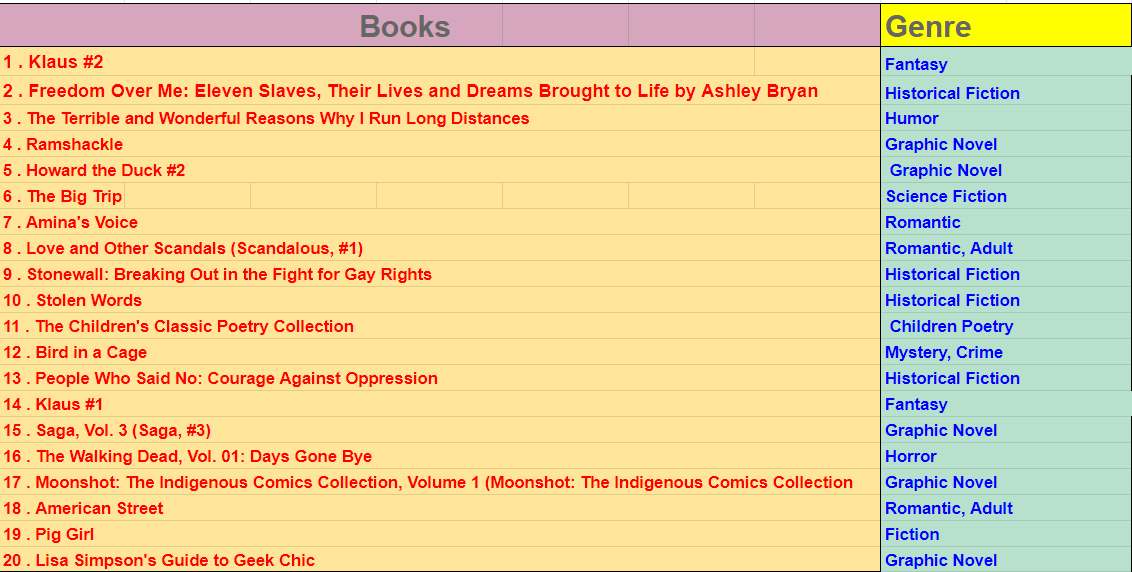



*   Graphic Novel  -   5
*   Historical Fiction - 	4
*   Romantic, Adult - 	3
*   Fantasy - 	2
*   Science Fiction	-   1
*   Children Poetry - 	1
*   Mystery, Crime - 	1
*   Horror - 	1
--------------------------------------------------------------
1- We found that Collaborative Filtering(SVD(Singular-Valued Decomposition) recommends best mix of books as per user taste.

2- Secondly Collaborative Filtering(User-User Similarity Recommendation) also performs quite good and recommends books only from the category which user has read in past.

3- Content Based Filetring models also performs good, taking into the consideration at the data we have(model would have given better choices if we have some more details about user). 

---------------------------------------------------------------- 


Analysing our recommendations using Book-id : 23017947, it's very hard to say which model gives best result.

1- All models are beating out each other performance, either it's model giving recommendation based on review, collaborative filtering based(Item-Item Recommended model), Model giving recommendations using similar-cover page all provided best match choices.

2- Correlation Based model seems to be providing quite logical recommendations, precisely if we look at its recommendation pattern it recommends exactly matching taste but covers larger domain.

3- All other models like title based similarity or description based similarity also made best suggestions with the keywords they obtained.


------------------------------------------------------------------------









